In [30]:
import os
import pandas as pd
import numpy as np
from glob import glob
import nibabel as nib
from nilearn.plotting import plot_img, plot_stat_map, view_img, plot_prob_atlas
from nilearn.glm.first_level.hemodynamic_models import spm_hrf
from nilearn.image import concat_imgs, mean_img, index_img, smooth_img
from nilearn.glm import threshold_stats_img
import matplotlib.pyplot as plt
from nilearn.plotting import plot_roi
from nilearn.maskers import NiftiSpheresMasker
from scipy.interpolate import interp1d
import seaborn as sns
from scipy.stats.mstats import pearsonr
from scipy.stats import zscore
import scipy.stats as stats


Possibilities: 
- Currently the coordinates are in Tailarach, but the func files are in MNI. Even though, the masker object accepts both TAL and MNI coordinates, transform current coordinates to see if it makes a difference. 
- Compare released and un-released movies. 
- Onset of NAcc and middle MPFC. 
- MPFC 2 tr after nacc and ains.

- Split like and no-like horror movies. 

- Also, calculate slope between tr_1 and tr_2 that crosses a 1 std. 
- Get the highest correlation for comedy, see when TR happens. 
- What to do if there's more than one peak (i.e., if there's more than two points higher than std)?
- Try region coupling (MPFC-NAcc, MPFC-AIns, NAcc-AIns).

- Look into rank transform for gross. 
- Individual choice, NAcc validiity for individual.
- For horror is NAcc predicting individual choice. 


# Homemade functions

In [31]:
def Merge(dict1, dict2):

    # create a new dictionary by merging the items of the two dictionaries using the union operator (|)
    merged_dict = dict(dict1.items() | dict2.items())
    
    # return the merged dictionary
    return merged_dict

def merge_dictionaries(dict1, dict2):
    merged_dict = dict1.copy()
    merged_dict.update(dict2)
    return merged_dict

In [32]:
def get_individual_peak(timecourse, max_min):

    # Get the maximum peak of the timecourse.
    if(max_min == 'max'):
        peak_id = np.argmax(timecourse)
    elif(max_min == 'min'):
        peak_id = np.argmin(timecourse)
    else: 
        print("Incorrect max_min value. Please use 'max' or 'min'.")

    # Check if the peak is the first or last timepoint.
    # If    
    if(peak_id == 0):
        peak = np.mean(timecourse[peak_id:peak_id+1])
    elif(peak_id == len(timecourse)-1):
        #peak = np.mean(timecourse[peak_id-1:peak_id])
        peak = timecourse[peak_id]
    else:
        peak = np.mean(timecourse[peak_id:peak_id+1])
    
    return peak


  

In [33]:
# Functions to get different peaks (slope and deltas).
def get_peak_slope(timecourse, timecourse_z, z_threshold, max_min):

    # Store all possible peak in timecourse array.
    possible_slope_peaks = []

    # Loop through each point in timecourse array, except the first one.
    for id_tr in range(1, 15, 1):

        # For positive peaks. 
        if(max_min == "max"):

            # If score is bigger than "z_threshold" z-score in timecourse_z array, append value.
            if(timecourse_z[id_tr] > z_threshold): 

                slope = timecourse[id_tr] - timecourse[id_tr - 1] 
                # Check the slope is not equal to zero. 
                if(slope != 0):
                    possible_slope_peaks.append(slope)
        
        # For negative peaks.
        if(max_min == "min"):

            # If score is bigger than "z_threshold" z-score in timecourse_z array, append value.
            if(timecourse_z[id_tr] < z_threshold): 

                slope = timecourse[id_tr] - timecourse[id_tr - 1] 
                # Check the slope is not equal to zero. 
                if(slope != 0):
                    possible_slope_peaks.append(slope)
    
    average_slope = np.mean(possible_slope_peaks)

    # Return only the first value and average slope.
    if(len(possible_slope_peaks) == 0):
        return 0, 0
    else: 
        return possible_slope_peaks[0], average_slope

def get_narrow_peak_slope(timecourse, z_threshold, max_min):

    # Z-score the 15 data points.
    z_scored_data = stats.zscore(timecourse)

    # Store all possible peak in timecourse array.
    possible_slope_peaks = []

    # Loop through each point in timecourse array, except the first one.
    for id_tr in range(1, 15, 1):

        # For positive peaks.
        if(max_min == "max"):
            # If score is bigger than "z_threshold" z-score in timecourse_z array, append value.
            if(z_scored_data[id_tr] > z_threshold): 

                slope = timecourse[id_tr] - timecourse[id_tr - 1] 
                # Check the slope is not equal to zero. 
                if(slope != 0):
                    possible_slope_peaks.append(slope)
    
        # For negative peaks.
        if(max_min == "min"):
            # If score is bigger than "z_threshold" z-score in timecourse_z array, append value.
            if(z_scored_data[id_tr] < z_threshold): 

                slope = timecourse[id_tr] - timecourse[id_tr - 1] 
                # Check the slope is not equal to zero. 
                if(slope != 0):
                    possible_slope_peaks.append(slope)
    
    average_slope = np.mean(possible_slope_peaks)

    # Return only the first value and average slope.
    if(len(possible_slope_peaks) == 0):
        return 0, 0
    else: 
        return possible_slope_peaks[0], average_slope
    
def get_peak_delta(timecourse, timecourse_z, z_threshold, max_min):

    # Store all possible peak in timecourse array.
    possible_delta_peaks = []

    # Loop through each point in timecourse array, except the first one.
    for id_tr in range(1, 15, 1):

        # For positive peaks. 
        if(max_min == "max"):

            # If score is bigger than "z_threshold" z-score in timecourse_z array, append value.
            if(timecourse_z[id_tr] > z_threshold): 

                delta = (timecourse[id_tr] - timecourse[id_tr - 1])/(timecourse[id_tr]*100) 
                #delta = (timecourse[id_tr] - timecourse[id_tr - 1])/(timecourse[id_tr] + timecourse[id_tr - 1]) 
                # Check the slope is not equal to zero. 
                if(delta != 0):
                    possible_delta_peaks.append(delta)
        
        # For negative peaks.
        if(max_min == "min"):

            # If score is bigger than "z_threshold" z-score in timecourse_z array, append value.
            if(timecourse_z[id_tr] < z_threshold): 

                delta = (timecourse[id_tr] - timecourse[id_tr - 1])/(timecourse[id_tr]*100) 
                #delta = (timecourse[id_tr] - timecourse[id_tr - 1])/(timecourse[id_tr] + timecourse[id_tr - 1]) 
                # Check the slope is not equal to zero. 
                if(delta != 0):
                    possible_delta_peaks.append(delta)
    
    average_delta = np.mean(possible_delta_peaks)

    # Return only the first value and average slope.
    if(len(possible_delta_peaks) == 0):
        return 0, 0
    else: 
        return possible_delta_peaks[0], average_delta
    
def get_narrow_peak_delta(timecourse, z_threshold, max_min):

    # Z-score the 15 data points.
    z_scored_data = stats.zscore(timecourse)

    # Store all possible peak in timecourse array.
    possible_delta_peaks = []

    # Loop through each point in timecourse array, except the first one.
    for id_tr in range(1, 15, 1):

        # For positive peaks.
        if(max_min == "max"):
            # If score is bigger than "z_threshold" z-score in timecourse_z array, append value.
            if(z_scored_data[id_tr] > z_threshold): 

                delta = (timecourse[id_tr] - timecourse[id_tr - 1])/(timecourse[id_tr]*100) 
                #delta = (timecourse[id_tr] - timecourse[id_tr - 1])/(timecourse[id_tr] + timecourse[id_tr - 1]) 
                # Check the slope is not equal to zero. 
                if(delta != 0):
                    possible_delta_peaks.append(delta)
    
        # For negative peaks.
        if(max_min == "min"):
            # If score is bigger than "z_threshold" z-score in timecourse_z array, append value.
            if(z_scored_data[id_tr] < z_threshold): 

                delta = (timecourse[id_tr] - timecourse[id_tr - 1])/(timecourse[id_tr]*100) 
                #delta = (timecourse[id_tr] - timecourse[id_tr - 1])/(timecourse[id_tr] + timecourse[id_tr - 1]) 
                # Check the slope is not equal to zero. 
                if(delta != 0):
                    possible_delta_peaks.append(delta)
    
    average_delta = np.mean(possible_delta_peaks)

    # Return only the first value and average slope.
    if(len(possible_delta_peaks) == 0):
        return 0, 0
    else: 
        return possible_delta_peaks[0], average_delta
     


In [34]:
def plot_trailer_correlations(ROI_df, Trailer_id, ROI_id, TR_corr_dict, type_of_corr, axs):

    if(type_of_corr == "W_score"):
        color="green"
        bonus_y = 0.00
        score_label = "_w"
        text_label = "W corr"
    elif(type_of_corr == "Pos_arousal"):
        color="blue"
        bonus_y = 0.05
        score_label = "_pa"
        text_label = "PA corr"
    elif(type_of_corr == "Neg_arousal"):
        color="red"
        bonus_y = -0.05
        score_label = "_na"
        text_label = "NA corr"

    if(ROI_id == "Bilateral_NAcc"):
        y_coord_seg = 0.3 + bonus_y
        y_coord_whole = 0.4
    elif(ROI_id == "Bilateral_AIns"):
        y_coord_seg = 0.4 + bonus_y
        y_coord_whole = 0.5
    elif(ROI_id == "Bilateral_MPFC"):
        y_coord_seg = 0.4 + bonus_y
        y_coord_whole = 0.5

    # Get the dataframe for the current trailer.
    current_traile_df = ROI_df[Trailer_id]

    # Loop for plotting each significant correlation across the 15 TRs.
    for TR_id in range(15):
        TR_label = str("TR_" + str(TR_id) + score_label) 
        y_coord = current_traile_df[(current_traile_df["ROI"] == ROI_id) & (current_traile_df["TR"] == TR_id)]["Signal"].mean() + bonus_y
        x_coord = TR_id
        if(TR_corr_dict[Trailer_id][TR_label][1] < 0.05):
            if(TR_corr_dict[Trailer_id][TR_label][0] > 0):
                axs.text(x_coord, y_coord, "+*", fontsize=13, color=color, weight="bold", label=text_label)
            else:
                axs.text(x_coord, y_coord, "-*", fontsize=13, color=color, weight="bold", label=text_label)
    
    # Plot the onset correlation if significant.
    #current_traile_df = ROI_df[Trailer_id]
    Onset_label = str("Onset" + score_label)
    #y_coord_seg = (current_traile_df[(current_traile_df["ROI"] == ROI_id)]["Signal"].mean() ) + bonus_y #* 0.7
    x_coord_onset = 3

    if(TR_corr_dict[Trailer_id][Onset_label][1] < 0.05):
        if(TR_corr_dict[Trailer_id][Onset_label][0] > 0):
            axs.text(x_coord_onset, y_coord_seg, "on(+)", fontsize=13, color=color, weight="bold", label=text_label)
        else:
            axs.text(x_coord_onset, y_coord_seg, "on(-)", fontsize=13, color=color, weight="bold", label=text_label)

    # Plot the middle correlation if significant.
    Middle_label = str("Middle" + score_label)
    x_coord_middle = 7
    if(TR_corr_dict[Trailer_id][Middle_label][1] < 0.05):
        if(TR_corr_dict[Trailer_id][Middle_label][0] > 0):
            axs.text(x_coord_middle, y_coord_seg, "mid(+)", fontsize=13, color=color, weight="bold", label=text_label)
        else:
            axs.text(x_coord_middle, y_coord_seg, "mid(-)", fontsize=13, color=color, weight="bold", label=text_label)

    # Plot the offset correlation if significant.
    Offset_label = str("Offset" + score_label)
    x_coord_offset = 13
    if(TR_corr_dict[Trailer_id][Offset_label][1] < 0.05):
        if(TR_corr_dict[Trailer_id][Offset_label][0] > 0):
            axs.text(x_coord_offset, y_coord_seg, "off(+)", fontsize=13, color=color, weight="bold", label=text_label)
        else:
            axs.text(x_coord_offset, y_coord_seg, "off(-)", fontsize=13, color=color, weight="bold", label=text_label)

    # Plot the whole correlation if significant.
    Whole_label = str("Whole" + score_label)
    x_coord_whole = 7
    #y_coord_whole = (current_traile_df[(current_traile_df["ROI"] == ROI_id)]["Signal"].max() ) + bonus_y # * 0.8
    if(TR_corr_dict[Trailer_id][Whole_label][1] < 0.05):
        if(TR_corr_dict[Trailer_id][Whole_label][0] > 0):
            axs.text(x_coord_whole, y_coord_whole, "whole(+)", fontsize=13, color=color, weight="bold", label=text_label)
        else:
            axs.text(x_coord_whole, y_coord_whole, "whole(-)", fontsize=13, color=color, weight="bold", label=text_label)
    



In [35]:
# Define a function to invert scores if needed. 
def transform_scores(score, invert):
    if(invert==1): #if(not invert):
        if(score == 1):  
            return 4
        elif(score == 2):  
            return 3
        elif(score == 3):  
            return 2
        elif(score == 4):  
            return 1
        elif(score == "1"):  
            return 4
        elif(score == "2"):  
            return 3
        elif(score == "3"):  
            return 2
        elif(score == "4"):  
            return 1
        elif(score == "None"):
            return 0
        else: 
            return "Something went wrong here!"
    else:
        if(score == "1"):
            return 1
        elif(score == "2"):
            return 2
        elif(score == "3"):
            return 3
        elif(score == "4"):
            return 4
        elif(score == 1):
            return 1
        elif(score == 2):
            return 2
        elif(score == 3):
            return 3
        elif(score == 4):
            return 4
        elif(score == "None"):
            return 0
        else:
            return "Something went wrong here!"

In [36]:
# Percent signal change .
def get_psc(timecourse):

   # Get number of ROIs and data points in timecourse.
   roi_num = timecourse.shape[1]
   data_length = timecourse.shape[0]

   # Copy timecourse into new array.
   psc_timecourse = np.zeros(timecourse.shape)

   # Warning for empty arrays. 
   if(roi_num ==0):
      print("Watch out, this array is empty!")

   # Loop through every ROI and derive the psc. 
   for id in range(roi_num):

      current_roi_avg = np.mean(timecourse[:, id], axis=0)

      for idx in range(data_length):

         # Formula to get percent signal change -> ((point-avg)/avg)*100.
         psc_timecourse[idx, id] = ((timecourse[idx, id] - current_roi_avg)/ current_roi_avg)*100

   return psc_timecourse

In [37]:
def process_events_data(run_dataframe):

    proccesed_events_df = pd.DataFrame(columns={"Trailer", "Type", "Onset", "Duration", "Offset", "W_score", "A_score", "F_score"}) 

    # Initial fixation 12 sec (TR=6).
    in_fix = 12

    # Time it take subjects to complete questionnaire 12 sec (TR=6). 
    questionnaire_duration = 12

    # All trailers last 30 sec (TR=15). 
    trailer_duration = 30

    # Initialize this variable, though it will change through each iteration of the loop.
    trailer_onset = 0

    # Run a for loop for each row in the df. 
    for id in range(run_dataframe.shape[0]):

        # Get trailer label and separate them accroding to their type. 
        trailer_name = run_dataframe["label"][id]
        trailer_type = "Horror" if "h" in run_dataframe["label"][id] else "Comedy"

        # This onsets don't work, so I need to re-calculate them
        traile_iti = run_dataframe["trial_ITI"][id]
        
        # For the first run add the initial fixation time to the calculation of the first trailer onset. 
        # After the first run, calculate onset by adding previous traile onset, questionnaire duration, and trial iti.
        if (id == 0):
            trailer_onset += in_fix
        else:
            trailer_onset += trailer_duration + questionnaire_duration + traile_iti

        # Calculate trailer onset. 
        trailer_offset = trailer_onset + 30 

        """ 
        For the questionnaire scores, as I understood it. If they were not inverted (["scale_flip"] == 0), then 
        the lower the score the stronger the response. If they were inverted (["scale_flip"] == 1), the higher the 
        score the stronger the response.
        """
        # Check if scaled was flipped and put scores on the same scale. 
        # For me, the most intuitive is that the higher the score, the stronger the response. 
        trailer_watch_score = transform_scores(run_dataframe["exp_Watch.keys"][id], run_dataframe["scale_flip"][id])
        trailer_arousal_score = transform_scores(run_dataframe["exp_Arousal.keys"][id], run_dataframe["scale_flip"][id])
        trailer_feel_score = transform_scores(run_dataframe["exp_Feel.keys"][id], run_dataframe["scale_flip"][id])

        # Place processed data on list, add list to new dataframe, and concat to main dataframe. 
        current_row_data = [[trailer_name, trailer_type, trailer_onset, trailer_duration, trailer_offset, trailer_watch_score, trailer_arousal_score, trailer_feel_score]]
        current_row = pd.DataFrame(data=current_row_data, columns=["Trailer", "Type", "Onset", "Duration", "Offset", "W_score", "A_score", "F_score"]) 
        proccesed_events_df = pd.concat([proccesed_events_df, current_row], ignore_index=True)
        proccesed_events_df = proccesed_events_df[["Trailer", "Type", "Onset", "Offset", "Duration", "W_score", "A_score", "F_score"]]

    # Add a column for the mean centered arousal and valence scores.
    mean_centered_arousal = proccesed_events_df["A_score"]/proccesed_events_df["A_score"].mean()
    mean_centered_valence = proccesed_events_df["F_score"]/proccesed_events_df["F_score"].mean()

    # Derive the positive and negative arousal scores.
    proccesed_events_df["Pos_arousal"] = (mean_centered_arousal+mean_centered_valence)/np.sqrt(2)
    proccesed_events_df["Neg_arousal"] = (mean_centered_arousal-mean_centered_valence)/np.sqrt(2)

    # Derive the positive and negative arousal scaled scores. 
    pos_arousal_mean = proccesed_events_df["Pos_arousal"].mean()
    neg_arousal_mean = proccesed_events_df["Neg_arousal"].mean()

    pos_arousal_std = np.std(proccesed_events_df["Pos_arousal"], axis=0, ddof=1)
    neg_arousal_std = np.std(proccesed_events_df["Neg_arousal"], axis=0, ddof=1)

    proccesed_events_df["Pos_arousal_scaled"] = (proccesed_events_df["Pos_arousal"] - pos_arousal_mean)
    proccesed_events_df["Neg_arousal_scaled"] = (proccesed_events_df["Neg_arousal"] - neg_arousal_mean)

    # Derive scales Watch scores. 
    watch_score_mean = proccesed_events_df["W_score"].mean()    
    watch_score_std = np.std(proccesed_events_df["W_score"], axis=0, ddof=1)
    proccesed_events_df["W_score_scaled"] = (proccesed_events_df["W_score"] - watch_score_mean)

    return proccesed_events_df

In [38]:
def access_trailer(dictionary, trailer_key): 
    try:
        trailer_data = dictionary[trailer_key]
        return trailer_data
    except KeyError:
        pass    

def access_timecourse(dictionary, roi_key):
    
    dictionary_keys = list(dictionary.keys())

    if((roi_key in dictionary_keys) and (dictionary[roi_key] is not None) and (dictionary[roi_key] is not "None")):
        roi_data = np.array(dictionary[roi_key])
        return roi_data
    
    
    # try:
    #     print(dictionary)
    #     if(dictionary[roi_key] == None):
    #         print("This is empty!")
    #         print(dictionary[roi_key])
    #     if(dictionary[roi_key] is not None):
    #         roi_data = np.array(dictionary[roi_key])
    #         return roi_data
    
    # except KeyError:
    #     pass

def trim_timecourse_per_roi(timecourses_dictionary_list, timecourses_dictionary_raw, ROI):

    # 1) Create a new dictionary to store the trimmed timecourses.
    # First file will store the avg timecourse for each trailer per roi (ROI x trailer).
    # Second file will store the timecourse of all subjects for each trailer per roi (ROI x subjects x trailer).
    # Third file will store the timecourse of all subjects for each trailer per roi in a dataframe (ROI x subjects x trailer).
    all_subjects_avg_ROI_timecourse = {}
    all_subjects_ROI_timecourse = {}
    all_subjects_ROI_timecourse_df = {}

    bROI = "Bilateral_" + ROI
    bROI_r1 = "Bilateral_" + ROI + "_r1"
    bROI_r2 = "Bilateral_" + ROI + "_r2"
    rROI = "Right_" + ROI
    rROI_r1 = "Right_" + ROI + "_r1"
    rROI_r2 = "Right_" + ROI + "_r2"
    lROI = "Left_" + ROI
    lROI_r1 = "Left_" + ROI + "_r1"
    lROI_r2 = "Left_" + ROI + "_r2"

    # Get all keys from the first participant dictionary.
    trailer_list = list(timecourses_dictionary_list["sub-01"].keys())
    subjects_list = list(timecourses_dictionary_raw.keys())

    if(ROI != "V1"):
        # Loop through all trailer keys.
        for id in range(len(trailer_list)): 
    
            # Create new participant list with only participants that have the current trailer.
            participants_with_trailer = [d for d in timecourses_dictionary_list if trailer_list[id] in timecourses_dictionary_list[d]] # Store participant id if they have the current trailer.
        
            # Make copy of dictionary with only participants that have the current trailer.
            timecourses_dictionary_list_current_trailer = {k: timecourses_dictionary_list[k] for k in participants_with_trailer}
        
            # Loop through all participants and get the values for the current trailer.
            # Note, a wrapper function just to return the values for the current trailer.
            # if they exist, otherwise return None.
            values = [access_trailer(timecourses_dictionary_list_current_trailer[d], trailer_list[id]) for d in timecourses_dictionary_list_current_trailer] 
        
            values_Bilateral_ROI = [values[d][bROI] for d in range(len(values))]
            values_Right_ROI = [values[d][rROI] for d in range(len(values))]
            values_Left_ROI = [values[d][lROI] for d in range(len(values))]

            # Compute the average for each roi.
            averageBilateral_ROI = np.mean(values_Bilateral_ROI, axis=0)
            averageRight_ROI = np.mean(values_Right_ROI, axis=0)
            averageLeft_ROI = np.mean(values_Left_ROI, axis=0)

            # Row are timepoints, columns are participants (15 x P).
            values_Bilateral_ROI_array = np.array(values_Bilateral_ROI).T 
            values_Right_ROI_array = np.array(values_Right_ROI).T
            values_Left_ROI_array = np.array(values_Left_ROI).T

            # Create columns names for the dataframe.
            TRs = np.arange(0, 15, 1)

            # Creat empty dataframe for current trailer. 
            trailer_df = pd.DataFrame(columns=["Participant", "ROI", "Signal", "TR"])   

            current_participant_dic = {}

            for current_participant in range(len(participants_with_trailer)):

                # Create dictionary with all the timecourses for all trailers for each subject.
                current_participant_dic[participants_with_trailer[current_participant]] = {bROI: values_Bilateral_ROI_array[:, current_participant],
                                                                                       lROI: values_Left_ROI_array[:, current_participant], 
                                                                                       rROI: values_Right_ROI_array[:, current_participant]}
 
                participant_col = np.repeat(str(participants_with_trailer[current_participant]), 15)
                label_bi = np.repeat(bROI, 15)
                label_left = np.repeat(lROI, 15)
                label_right = np.repeat(rROI, 15)
                roi_labels = [label_bi, label_left, label_right]

                # Store current participant values. 
                current_participant_bi = values_Bilateral_ROI_array[:, current_participant]
                current_participant_left = values_Left_ROI_array[:, current_participant]
                current_participant_right = values_Right_ROI_array[:, current_participant]
                current_participant_values = [current_participant_bi, current_participant_left, current_participant_right]

                for x in range(3):

                    current_participant_roi_data = {
                        "Participant": participant_col,
                        "ROI": roi_labels[x],
                        "Signal": current_participant_values[x],
                        "TR": TRs
                    }
            
                    participant_df = pd.DataFrame(data=current_participant_roi_data)

                    trailer_df = pd.concat([trailer_df, participant_df], ignore_index=True)
        
            # store the all in the results dictionaries.
            all_subjects_avg_ROI_timecourse[trailer_list[id]] = {bROI: averageBilateral_ROI, lROI: averageLeft_ROI, rROI: averageRight_ROI}
            all_subjects_ROI_timecourse[trailer_list[id]] = current_participant_dic
            all_subjects_ROI_timecourse_df[trailer_list[id]] = trailer_df
    
    # Get average timecourse for all subjects in the current ROI. 
    Bilateral_ROI_raw_r1_list = [access_timecourse(timecourses_dictionary_raw[sub_id], bROI_r1) for sub_id in subjects_list] # if timecourses_dictionary_raw[sub_id][bROI_r1] is not None
    Bilateral_ROI_raw_r2_list = [access_timecourse(timecourses_dictionary_raw[sub_id], bROI_r2) for sub_id in subjects_list]
    Right_ROI_raw_r1_list = [access_timecourse(timecourses_dictionary_raw[sub_id], rROI_r1) for sub_id in subjects_list]
    Right_ROI_raw_r2_list = [access_timecourse(timecourses_dictionary_raw[sub_id], rROI_r2) for sub_id in subjects_list]
    Left_ROI_raw_r1_list = [access_timecourse(timecourses_dictionary_raw[sub_id], lROI_r1) for sub_id in subjects_list]
    Left_ROI_raw_r2_list = [access_timecourse(timecourses_dictionary_raw[sub_id], lROI_r2) for sub_id in subjects_list]    

    # Remove None values from the list.
    Bilateral_ROI_raw_r1_list = [x for x in Bilateral_ROI_raw_r1_list if x is not None]
    Bilateral_ROI_raw_r2_list = [x for x in Bilateral_ROI_raw_r2_list if x is not None]
    Right_ROI_raw_r1_list = [x for x in Right_ROI_raw_r1_list if x is not None]
    Right_ROI_raw_r2_list = [x for x in Right_ROI_raw_r2_list if x is not None]
    Left_ROI_raw_r1_list = [x for x in Left_ROI_raw_r1_list if x is not None]
    Left_ROI_raw_r2_list = [x for x in Left_ROI_raw_r2_list if x is not None]

    # Get the average timecourse for all subjects in the current ROI.
    Bilateral_ROI_raw_r1_average = np.mean(Bilateral_ROI_raw_r1_list, axis=0)
    Bilateral_ROI_raw_r2_average = np.mean(Bilateral_ROI_raw_r2_list, axis=0)
    Right_ROI_raw_r1_average = np.mean(Right_ROI_raw_r1_list, axis=0)
    Right_ROI_raw_r2_average = np.mean(Right_ROI_raw_r2_list, axis=0)
    Left_ROI_raw_r1_average = np.mean(Left_ROI_raw_r1_list, axis=0)
    Left_ROI_raw_r2_average = np.mean(Left_ROI_raw_r2_list, axis=0)

    # Create TR array.
    TRs_raw = np.arange(0, 378, 1)

    # Put everything in a list 
    ROI_raw_list = [Bilateral_ROI_raw_r1_average, Bilateral_ROI_raw_r2_average, Right_ROI_raw_r1_average, Right_ROI_raw_r2_average, Left_ROI_raw_r1_average, Left_ROI_raw_r2_average]
    ROI_raw_labels = [bROI_r1, bROI_r2, rROI_r1, rROI_r2, lROI_r1, lROI_r2]

    # Creat empty dataframe. 
    all_subjects_avg_ROI_timecourse_raw_df = pd.DataFrame(columns=["ROI", "Signal", "TR"])  

    for ROI_id in range(6):

        current_roi_data = {        
            "ROI": ROI_raw_labels[ROI_id],
            "Signal": ROI_raw_list[ROI_id],
            "TR": TRs_raw}
            
        current_roi_df = pd.DataFrame(data=current_roi_data)

        all_subjects_avg_ROI_timecourse_raw_df = pd.concat([all_subjects_avg_ROI_timecourse_raw_df, current_roi_df], ignore_index=True)


    return all_subjects_avg_ROI_timecourse, all_subjects_ROI_timecourse, all_subjects_ROI_timecourse_df, all_subjects_avg_ROI_timecourse_raw_df


<>:12: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:12: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/var/folders/0z/1yt2h6410kb7_mgghf4q28z00000gn/T/ipykernel_8613/3086786338.py:12: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if((roi_key in dictionary_keys) and (dictionary[roi_key] is not None) and (dictionary[roi_key] is not "None")):


In [39]:
# Taken from: https://bioimagesuiteweb.github.io/webapp/mni2tal.html
# Note, I am not transforming the coordinates, instead I am using the MNI coordinates 
# that the site suggests correspond to each region.
mni_coords = {
    "NAcc_RL": [(10, 10, -12), (-11, 9, -11)],
    "MPFC_RL": [(12, 37, -19), (-11, 38, -18)],
    "AIns_RL": [(36, 18, -4), (-36, 18, 4)], # Not sure about this one.
}

# Taken from (Genevsky et al., 2017). -> NAcc, MPFC, AIns. 
tal_coords = {
    "NAcc_RL": [(10, 12, -2), (-10, 12, -2)], # Nucleus accumbes (NAcc) right, left
    "MPFC_RL": [(4, 45, 0), (-4, 45, 0)], # Medial prefrontal cortex (MPFC) right, left
    "AIns_RL": [(34, 24, -4), (-34, 24, -4)] # Anterior Insula right, left
}

In [40]:

def getROIs_timecourse(participant_num, sub_motion): 

    ## 1) Load data.
    # Load relevant files for participant
    sub_run1_func_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
    sub_run2_func_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"

    sub_run1_mask_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-01_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"
    sub_run2_mask_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-02_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"

    sub_run1_events_path = "MovieData_BIDS_raw/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-01_events.csv"
    sub_run2_events_path = "MovieData_BIDS_raw/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-02_events.csv"

    sub_run1_confounds_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-01_desc-confounds_timeseries.tsv"
    sub_run2_confounds_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-02_desc-confounds_timeseries.tsv"

    # Calculate relevant parameters for GLM and ROI time-course analysis.
    func_file = nib.load(sub_run1_func_path)
    func_data = func_file.get_fdata()
    n_vols = func_data.shape[3]
    TR = 2
    n_timepoints = n_vols*TR

    # Load raw events files. 
    sub_run1_events_df = pd.read_csv(sub_run1_events_path, index_col=0)
    sub_run2_events_df = pd.read_csv(sub_run2_events_path, index_col=0)

    ## 2) Process files. 
    # Process event files. 
    sub_run1_p_events = process_events_data(sub_run1_events_df)
    sub_run2_p_events = process_events_data(sub_run2_events_df)

    # Down-sample time onsets to get vol onsets. 
    # Create array from 0 to 'n_timepoints' in steps of 1.
    time_scale = np.arange(0, n_timepoints, 1)  

    # Create array from 0 to 'n_timepoints' in steps of 2.
    vol_scale = np.arange(0, n_timepoints, TR)  

    # Get the labels of each trailer for each run. 
    run1_trailer_labels = sub_run1_p_events["Trailer"].tolist()
    run2_trailer_labels = sub_run2_p_events["Trailer"].tolist()

    # Create dictionary variable to store arrays with onset values for each trailer. 
    run1_onsets = {}
    run2_onsets = {}

    # Create a dictionary with all the onsets for each trailer in each run. 
    for id in range(len(run1_trailer_labels)):

        # Create array of zeros.
        run1_trailer_onsets = np.zeros(n_timepoints)
        run2_trailer_onsets = np.zeros(n_timepoints)

        # Get onset time. 
        run1_current_trailer_onset = sub_run1_p_events["Onset"][id]
        run2_current_trailer_onset = sub_run2_p_events["Onset"][id]

        # Assign 1 to such onset all the way til the end of the trailer (30 sec) in the array of zeros.
        # Adjust for lag: add 4 seconds at the onset and offset
        # Let's add 4 seconds to the onset and offset to account for the lag in the BOLD signal.
        run1_trailer_onsets[int(run1_current_trailer_onset + 4):int(run1_current_trailer_onset)+ 30 + 4] = 1
        run2_trailer_onsets[int(run2_current_trailer_onset + 4):int(run2_current_trailer_onset)+ 30 + 4] = 1
        #run1_trailer_onsets[int(run1_current_trailer_onset + 5):int(run1_current_trailer_onset)+ 30 + 5] = 1
        #run2_trailer_onsets[int(run2_current_trailer_onset + 5):int(run2_current_trailer_onset)+ 30 + 5] = 1

        # Create resampler objects for each trailer/run of reward.
        run1_resampler = interp1d(time_scale, run1_trailer_onsets)
        run2_resampler = interp1d(time_scale, run2_trailer_onsets)

        # Create downsampled arrays for each trailer. 
        # Note this vol arrays are half the length than the time arrays.
        run1_trailer_vol_onsets = run1_resampler(vol_scale)
        run2_trailer_vol_onsets = run2_resampler(vol_scale)

        # Append/store the downsampled volumes arrays to each dictionary.
        # I'm doing it this way, so the code is more interpretable
        run1_onsets[run1_trailer_labels[id]] = run1_trailer_vol_onsets
        run2_onsets[run2_trailer_labels[id]] = run2_trailer_vol_onsets

    ## 3) Load confound data. 
    sub_run1_confounds_df = pd.read_csv(sub_run1_confounds_path, sep='\t')
    sub_run2_confounds_df = pd.read_csv(sub_run2_confounds_path, sep='\t')
    default_confounds = ["white_matter", "csf", "csf_wm", "framewise_displacement", "dvars", "rmsd", "tcompcor"] 
    # ["white_matter", "csf", "csf_wm", "framewise_displacement",  "rmsd", "tcompcor"]
    
    # cohen_confounds = ['c_comp_cor_00','c_comp_cor_01','c_comp_cor_02','w_comp_cor_00','w_comp_cor_01','w_comp_cor_02',
    #                    'w_comp_cor_03','w_comp_cor_04','trans_x','trans_y','trans_z','rot_x','rot_y','rot_z','trans_x_derivative1'
    #                    ,'trans_y_derivative1','trans_z_derivative1','rot_x_derivative1','rot_y_derivative1','rot_z_derivative1',
    #                    'trans_x_power2','trans_y_power2','trans_z_power2','rot_x_power2','rot_y_power2','rot_z_power2',
    #                    'trans_x_derivative1_power2','trans_y_derivative1_power2','trans_z_derivative1_power2','rot_x_derivative1_power2',
    #                    'rot_y_derivative1_power2','rot_z_derivative1_power2','cosine00'] #, 'c_comp_cor_03', 'c_comp_cor_04'

    sub_run1_motion_s_confounds = [i for i in sub_run1_confounds_df.columns if "state" in i] 
    sub_run2_motion_s_confounds = [i for i in sub_run2_confounds_df.columns if "state" in i] 

    sub_run1_motion_confounds = [i for i in sub_run1_confounds_df.columns if "motion" in i] 
    sub_run2_motion_confounds = [i for i in sub_run2_confounds_df.columns if "motion" in i] 

    sub_run1_motion_rot_confounds = [i for i in sub_run1_confounds_df.columns if "rot" in i] 
    sub_run2_motion_rot_confounds = [i for i in sub_run2_confounds_df.columns if "rot" in i] 

    sub_run1_motion_trans_confounds = [i for i in sub_run1_confounds_df.columns if "trans" in i] 
    sub_run2_motion_trans_confounds = [i for i in sub_run2_confounds_df.columns if "trans" in i] 

    sub_run1_filtered_confounds_df = sub_run1_confounds_df[default_confounds + sub_run1_motion_s_confounds + sub_run1_motion_rot_confounds + sub_run1_motion_trans_confounds]
    sub_run2_filtered_confounds_df = sub_run2_confounds_df[default_confounds + sub_run2_motion_s_confounds + sub_run2_motion_rot_confounds + sub_run2_motion_trans_confounds]

    # sub_run1_cohen_confounds_df = sub_run1_confounds_df[cohen_confounds ] #+ sub_run1_motion_s_confounds
    # sub_run2_cohen_confounds_df = sub_run2_confounds_df[cohen_confounds ] #+ sub_run2_motion_s_confounds

    # Change NaNs to 0s. 
    sub_run1_filtered_confounds_df = sub_run1_filtered_confounds_df.fillna(0) 
    sub_run2_filtered_confounds_df = sub_run2_filtered_confounds_df.fillna(0) 

    # sub_run1_cohen_confounds_df = sub_run1_cohen_confounds_df.fillna(0) 
    # sub_run2_cohen_confounds_df = sub_run2_cohen_confounds_df.fillna(0) 

    # Declare parameters for Sphere Masker objects. 
    detrend = False
    standardize = "psc"
    standardize_confounds = "psc" 
    sphere_radius = 8 # from 6 to 8
    confounds1 = sub_run1_filtered_confounds_df
    confounds2 = sub_run2_filtered_confounds_df
    smoothing= 4 # from 6 to 4
    set_of_seeds = [(10, 12, -2), (-10, 12, -2), # Nucleus accumbes (NAcc) right, left
                (34, 24, -4), (-34, 24, -4), # Anterior Insula right (AIns), left
                (4, 45, 0), (-4, 45, 0), # Medial Prefrontal Cortex (MPFC) right, left
                (8, -76, 10), (-8, -76, 10)] # Visual cortex right, left

  
    ## 4) Apply mask to func data. 
    masker_AIM_ROI_r1 = NiftiSpheresMasker(
        seeds=set_of_seeds,
        allow_overlap=True,
        smoothing_fwhm=smoothing, 
        detrend=detrend,
        radius=sphere_radius, 
        mask_img=sub_run1_mask_path,
        standardize=standardize, 
        t_r=2,
        standardize_confounds=standardize_confounds,
        high_pass=1/360, # High cutoff frequency in Hertz. # Try 0.011
        #low_pass=0.1 # from 1.0
        )

    masker_AIM_ROI_r2 = NiftiSpheresMasker(
        seeds=set_of_seeds,
        allow_overlap=True,
        smoothing_fwhm=smoothing, 
        detrend=detrend,
        radius=sphere_radius, 
        mask_img=sub_run2_mask_path,
        standardize=standardize, 
        t_r=2,
        standardize_confounds=standardize_confounds,
        high_pass=1/360, # High cutoff frequency in Hertz. # Try 0.011
        #low_pass=0.1 # from 1.0
        )

    ROI_raw_timecourses = {}
    # Mask the func data and get a time series for the ROI. 
    # Note this is similar to fitting the GLM, but without the event files.
    ## Add if statement to only apply the masker if the run has acceptable motion parameters. 

    if((sub_motion[0] < 2) and (sub_motion[1] < 2)):

        # Apply function to get the percent signal change from each ROI timecourse. 
        sub_r1_AIM_ROI = masker_AIM_ROI_r1.fit_transform(sub_run1_func_path, confounds=confounds1)
        sub_r1_AIM_ROI_zscored = zscore(sub_r1_AIM_ROI, axis=1, nan_policy='omit')

        ## 5) Get the timecourses from each movie trailer. 
        # Create dictionary variable to store arrays with time series arrays for each trailer.
        run1_timeseries = {}
        run1_timeseries_zcored = {}

        # Get the trailers presented in each run. 
        r1_keys = list(run1_onsets.keys())

        # Loop through each trailer and get its corresponding ROI timecourse
        for id in range(len(r1_keys)):

            run1_timeseries[r1_keys[id]] = {
                "Bilateral_NAcc": np.mean(sub_r1_AIM_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 0:2], axis=1),
                "Left_NAcc": sub_r1_AIM_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 1],
                "Right_NAcc": sub_r1_AIM_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 0],
                "Bilateral_AIns": np.mean(sub_r1_AIM_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 2:4], axis=1),
                "Left_AIns": sub_r1_AIM_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 3],
                "Right_AIns": sub_r1_AIM_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 2],
                "Bilateral_MPFC": np.mean(sub_r1_AIM_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 4:6], axis=1),
                "Left_MPFC": sub_r1_AIM_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 5],
                "Right_MPFC": sub_r1_AIM_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 4]}
            
            run1_timeseries_zcored[r1_keys[id]] = {
                "Bilateral_NAcc_zscored": np.mean(sub_r1_AIM_ROI_zscored[run1_onsets[r1_keys[id]].astype(bool)][:, 0:2], axis=1),
                "Left_NAcc_zscored": sub_r1_AIM_ROI_zscored[run1_onsets[r1_keys[id]].astype(bool)][:, 1],
                "Right_NAcc_zscored": sub_r1_AIM_ROI_zscored[run1_onsets[r1_keys[id]].astype(bool)][:, 0],
                "Bilateral_AIns_zscored": np.mean(sub_r1_AIM_ROI_zscored[run1_onsets[r1_keys[id]].astype(bool)][:, 2:4], axis=1),
                "Left_AIns_zscored": sub_r1_AIM_ROI_zscored[run1_onsets[r1_keys[id]].astype(bool)][:, 3],
                "Right_AIns_zscored": sub_r1_AIM_ROI_zscored[run1_onsets[r1_keys[id]].astype(bool)][:, 2],
                "Bilateral_MPFC_zscored": np.mean(sub_r1_AIM_ROI_zscored[run1_onsets[r1_keys[id]].astype(bool)][:, 4:6], axis=1),
                "Left_MPFC_zscored": sub_r1_AIM_ROI_zscored[run1_onsets[r1_keys[id]].astype(bool)][:, 5],
                "Right_MPFC_zscored": sub_r1_AIM_ROI_zscored[run1_onsets[r1_keys[id]].astype(bool)][:, 4]}
        
        # This code gives me the un-trimmed timecourses for each ROI. 
        ROI_raw_timecourses["Bilateral_NAcc_r1"] = np.mean(sub_r1_AIM_ROI[:, 0:2], axis=1)
        ROI_raw_timecourses["Left_NAcc_r1"] = sub_r1_AIM_ROI[:, 1]
        ROI_raw_timecourses["Right_NAcc_r1"] = sub_r1_AIM_ROI[:, 0]
        ROI_raw_timecourses["Bilateral_AIns_r1"] = np.mean(sub_r1_AIM_ROI[:, 2:4], axis=1)
        ROI_raw_timecourses["Left_AIns_r1"] = sub_r1_AIM_ROI[:, 3]
        ROI_raw_timecourses["Right_AIns_r1"] = sub_r1_AIM_ROI[:, 2]
        ROI_raw_timecourses["Bilateral_MPFC_r1"] = np.mean(sub_r1_AIM_ROI[:, 4:6], axis=1)
        ROI_raw_timecourses["Left_MPFC_r1"] = sub_r1_AIM_ROI[:, 5]
        ROI_raw_timecourses["Right_MPFC_r1"] = sub_r1_AIM_ROI[:, 4]
        ROI_raw_timecourses["Bilateral_V1_r1"] = np.mean(sub_r1_AIM_ROI[:, 6:8], axis=1)
        ROI_raw_timecourses["Left_V1_r1"] = sub_r1_AIM_ROI[:, 6]
        ROI_raw_timecourses["Right_V1_r1"] = sub_r1_AIM_ROI[:, 7]

    # Apply for second run.
    if((sub_motion[2] < 2) and (sub_motion[3] < 2)):

        # Apply function to get the percent signal change from each ROI timecourse.
        sub_r2_AIM_ROI = masker_AIM_ROI_r2.fit_transform(sub_run2_func_path, confounds=confounds2)
        sub_r2_AIM_ROI_zscored = zscore(sub_r2_AIM_ROI, axis=1, nan_policy='omit')

        # Create dictionary variable to store arrays with time series arrays for each trailer.
        run2_timeseries = {}
        run2_timeseries_zcored = {}

        r2_keys = list(run2_onsets.keys())

        # Loop through each traile and get its corresponding ROI timecourse
        for id in range(len(r2_keys)):
            run2_timeseries[r2_keys[id]] = {
                "Bilateral_NAcc": np.mean(sub_r2_AIM_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 0:2], axis=1),
                "Left_NAcc": sub_r2_AIM_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 1],
                "Right_NAcc": sub_r2_AIM_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 0],
                "Bilateral_AIns": np.mean(sub_r2_AIM_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 2:4], axis=1),
                "Left_AIns": sub_r2_AIM_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 3],
                "Right_AIns": sub_r2_AIM_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 2],
                "Bilateral_MPFC": np.mean(sub_r2_AIM_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 4:6], axis=1),
                "Left_MPFC": sub_r2_AIM_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 5],
                "Right_MPFC": sub_r2_AIM_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 4]}

            run2_timeseries_zcored[r2_keys[id]] = {
                "Bilateral_NAcc_zscored": np.mean(sub_r2_AIM_ROI_zscored[run2_onsets[r2_keys[id]].astype(bool)][:, 0:2], axis=1),
                "Left_NAcc_zscored": sub_r2_AIM_ROI_zscored[run2_onsets[r2_keys[id]].astype(bool)][:, 1],
                "Right_NAcc_zscored": sub_r2_AIM_ROI_zscored[run2_onsets[r2_keys[id]].astype(bool)][:, 0],
                "Bilateral_AIns_zscored": np.mean(sub_r2_AIM_ROI_zscored[run2_onsets[r2_keys[id]].astype(bool)][:, 2:4], axis=1),
                "Left_AIns_zscored": sub_r2_AIM_ROI_zscored[run2_onsets[r2_keys[id]].astype(bool)][:, 3],
                "Right_AIns_zscored": sub_r2_AIM_ROI_zscored[run2_onsets[r2_keys[id]].astype(bool)][:, 2],
                "Bilateral_MPFC_zscored": np.mean(sub_r2_AIM_ROI_zscored[run2_onsets[r2_keys[id]].astype(bool)][:, 4:6], axis=1),
                "Left_MPFC_zscored": sub_r2_AIM_ROI_zscored[run2_onsets[r2_keys[id]].astype(bool)][:, 5],
                "Right_MPFC_zscored": sub_r2_AIM_ROI_zscored[run2_onsets[r2_keys[id]].astype(bool)][:, 4]}
        
        # This code gives me the un-trimmed timecourses for each ROI.
        ROI_raw_timecourses["Bilateral_NAcc_r2"] = np.mean(sub_r2_AIM_ROI[:, 0:2], axis=1)
        ROI_raw_timecourses["Left_NAcc_r2"] = sub_r2_AIM_ROI[:, 1]
        ROI_raw_timecourses["Right_NAcc_r2"] = sub_r2_AIM_ROI[:, 0]
        ROI_raw_timecourses["Bilateral_AIns_r2"] = np.mean(sub_r2_AIM_ROI[:, 2:4], axis=1)
        ROI_raw_timecourses["Left_AIns_r2"] = sub_r2_AIM_ROI[:, 3]
        ROI_raw_timecourses["Right_AIns_r2"] = sub_r2_AIM_ROI[:, 2]
        ROI_raw_timecourses["Bilateral_MPFC_r2"] = np.mean(sub_r2_AIM_ROI[:, 4:6], axis=1)
        ROI_raw_timecourses["Left_MPFC_r2"] = sub_r2_AIM_ROI[:, 5]
        ROI_raw_timecourses["Right_MPFC_r2"] = sub_r2_AIM_ROI[:, 4]
        ROI_raw_timecourses["Bilateral_V1_r2"] = np.mean(sub_r2_AIM_ROI[:, 6:8], axis=1)
        ROI_raw_timecourses["Left_V1_r2"] = sub_r2_AIM_ROI[:, 6]
        ROI_raw_timecourses["Right_V1_r2"] = sub_r2_AIM_ROI[:, 7]

    ## 6) Merge timecourses and events data. 
    if((sub_motion[0] < 2) and (sub_motion[2] < 2)): 

        # Merge the timecourses for both runs.
        all_timeseries = merge_dictionaries(run1_timeseries, run2_timeseries) 
        all_timeseries_zcored = merge_dictionaries(run1_timeseries_zcored, run2_timeseries_zcored)  
        sub_all_p_events = pd.concat([sub_run1_p_events, sub_run2_p_events], ignore_index=True)
        
        # Print message to indicate that the participant has acceptable data for both runs.
        #print("Participant " + participant_num + " has acceptable data for both runs.")

    elif((sub_motion[0] < 2) and (sub_motion[2] > 2)): 
        
        # Only data for first run. 
        all_timeseries = run1_timeseries
        all_timeseries_zcored = run1_timeseries_zcored
        sub_all_p_events = sub_run1_p_events
        #print("Participant " + participant_num + " has acceptable data for run 1 only.")
    elif((sub_motion[0] > 2) and (sub_motion[2] < 2)):

        # Only data for second run.
        all_timeseries = run2_timeseries
        all_timeseries_zcored = run2_timeseries_zcored
        sub_all_p_events = sub_run2_p_events
        #print("Participant " + participant_num + " has acceptable data for run 2 only.")
    else:
        #print("Participant " + participant_num + " has unacceptable data for both runs.")
        all_timeseries = {}
        all_timeseries_zcored = {}
        sub_all_p_events = []
    
    # Create dictionary to store all the relevant output. 
    Output_dic = { 
        "ROI_trimmed_timeseries": all_timeseries, 
        "ROI_trimmed_timeseries_zcored": all_timeseries_zcored,
        "Processes_events": sub_all_p_events, 
        "ROI_raw_timeseries": ROI_raw_timecourses
    }

    return Output_dic



# Get neural activation time courses. 

In [41]:
# Open a datasets directory. 
fd = os.open("/Users/luisalvarez/Documents/Datasets", os.O_RDONLY)

# Use os.fchdir() method to change the current dir/folder.
os.fchdir(fd)

# Safe check- Print current working directory
print("Current working dir : %s" % os.getcwd())

Current working dir : /Users/luisalvarez/Documents/Datasets


In [42]:
# Define each subject motion parameters from fMRIprep.
# The first value is the max framewise displacement, the second is the mean framewise displacement.
# Two values per run. 
sub01_motion = [0.911, 0.095, 0.571, 0.077]
sub02_motion = [0.663, 0.073, 0.734, 0.108]
sub03_motion = [0.456, 0.048, 0.300, 0.049]
sub04_motion = [0.607, 0.080, 0.519, 0.076]
#sub05_motion = [1.612, 0.138, 1.403, 0.208] # out both
sub05_motion = [2.0, 2.0, 2.0, 2.0] # out both
#sub06_motion = [3.008, 0.248, 4.225, 0.311] # out both
sub06_motion = [2.0, 2.0, 2.0, 2.0]
#sub07_motion = [8.275, 0.156, 0.531, 0.072] # out r1
sub07_motion = [2.0, 2.0, 2.0, 2.0]
sub08_motion = [0.597, 0.074, 0.482, 0.072] 
sub09_motion = [0.367, 0.069, 0.475, 0.104]
sub10_motion = [0.597, 0.074, 0.679, 0.103]
sub11_motion = [0.540, 0.059, 0.394, 0.055]
sub12_motion = [0.649, 0.154, 0.529, 0.162]
sub13_motion = [0.468, 0.091, 0.459, 0.102]
#sub14_motion = [2.538, 0.164, 1.245, 0.091] # out both
sub14_motion = [2.0, 2.0, 2.0, 2.0]
sub15_motion = [0.844, 0.066, 1.163, 0.062] # out r2
#sub16_motion = [0.688, 0.111, 3.026, 0.218] # out r2
sub16_motion = [2.0, 2.0, 2.0, 2.0]
sub17_motion = [0.626, 0.091, 0.376, 0.072]
sub18_motion = [0.777, 0.054, 0.699, 0.048]
sub19_motion = [1.593, 0.180, 0.789, 0.189] # out r1
#sub20_motion = [1.476, 0.091, 5.681, 0.167] # out both
sub20_motion = [2.0, 2.0, 2.0, 2.0]
sub21_motion = [0.935, 0.088, 0.856, 0.110]
sub22_motion = [0.729, 0.084, 1.021, 0.105] # out r2
sub23_motion = [0.582, 0.084, 0.496, 0.073] # head looks a bit weird
#sub24_motion = [1.406, 0.109, 1.550, 0.088] # out r1
sub24_motion = [2.0, 2.0, 2.0, 2.0]
sub25_motion = [0.649, 0.092, 0.351, 0.059]
sub26_motion = [0.894, 0.105, 0.965, 0.127]
sub27_motion = [0.525, 0.081, 0.494, 0.070]
sub28_motion = [1.001, 0.103, 0.494, 0.094] # out r1
sub29_motion = [0.300, 0.052, 0.330, 0.052]
sub30_motion = [0.269, 0.063, 0.335, 0.068]
sub31_motion = [0.398, 0.066, 0.377, 0.075]
sub32_motion = [0.817, 0.113, 1.551, 0.153] # out r2
sub33_motion = [0.959, 0.120, 0.627, 0.107]
sub34_motion = [0.344, 0.058, 0.309, 0.051]
sub35_motion = [0.656, 0.064, 0.704, 0.071]
sub36_motion = [0.790, 0.107, 0.746, 0.105]
sub37_motion = [0.560, 0.071, 0.585, 0.086]

participants_motion_list = [sub01_motion, sub02_motion, sub03_motion, sub04_motion, sub05_motion, sub06_motion, sub07_motion, sub08_motion, sub09_motion, sub10_motion, sub11_motion, sub12_motion, sub13_motion, sub14_motion, sub15_motion, sub16_motion, sub17_motion, sub18_motion, sub19_motion, sub20_motion, sub21_motion, sub22_motion, sub23_motion, sub24_motion, sub25_motion, sub26_motion, sub27_motion, sub28_motion, sub29_motion, sub30_motion, sub31_motion, sub32_motion, sub33_motion, sub34_motion, sub35_motion, sub36_motion, sub37_motion]

In [43]:
# Record the number with good data for each run. 
run1_subs_list = []
run2_subs_list = []
particpants_list = []

# Create relevant dictionaries. 
participant_dictionaries = {}
participant_dictionaries_zscored = {}
participant_dictionaries_raw = {}
participants_events = {}

for sub_id in range(len(participants_motion_list)):
    
    # Format participant number.
    current_sub = "sub-" + str(sub_id + 1).zfill(2)
    current_num = str(sub_id + 1).zfill(2)

    # Print message to indicate that the participant has been processed.
    current_sub_motion_r1 = participants_motion_list[sub_id][0]
    current_sub_motion_r2 = participants_motion_list[sub_id][2]

    # Get the timecourses for each participant.
    current_sub_dic = getROIs_timecourse(current_num, participants_motion_list[sub_id])

    # Append data to relevant dictionaries. 
    # Append the participant number to the list of participants.
    if((current_sub_motion_r1 < 2) and (current_sub_motion_r2 < 2)):
        participant_dictionaries[current_sub] = current_sub_dic["ROI_trimmed_timeseries"]
        participant_dictionaries_zscored[current_sub] = current_sub_dic["ROI_trimmed_timeseries_zcored"]
        participant_dictionaries_raw[current_sub] = current_sub_dic["ROI_raw_timeseries"]
        participants_events[current_sub] = current_sub_dic["Processes_events"]
        run1_subs_list.append(current_sub)
        run2_subs_list.append(current_sub)
        particpants_list.append(current_num)
        print("Participant " + current_sub + " has acceptable data for BOTH runs.")
    elif((current_sub_motion_r1 < 2) and (current_sub_motion_r2 > 2)):
        participant_dictionaries[current_sub] = current_sub_dic["ROI_trimmed_timeseries"]
        participant_dictionaries_zscored[current_sub] = current_sub_dic["ROI_trimmed_timeseries_zcored"]
        participant_dictionaries_raw[current_sub] = current_sub_dic["ROI_raw_timeseries"]
        participants_events[current_sub] = current_sub_dic["Processes_events"]
        run1_subs_list.append(current_sub)
        particpants_list.append(current_num)
        print("Participant " + current_sub + " has acceptable data for RUN_1 only.")
    elif((current_sub_motion_r1 > 2) and (current_sub_motion_r2 < 2)):
        participant_dictionaries[current_sub] = current_sub_dic["ROI_trimmed_timeseries"]
        participant_dictionaries_zscored[current_sub] = current_sub_dic["ROI_trimmed_timeseries_zcored"]
        participant_dictionaries_raw[current_sub] = current_sub_dic["ROI_raw_timeseries"]
        participants_events[current_sub] = current_sub_dic["Processes_events"]
        run2_subs_list.append(current_sub)
        particpants_list.append(current_num)
        print("Participant " + current_sub + " has acceptable data for RUN_2 only.")
    else:
        print("Participant " + current_sub + " has acceptable data for NONE of the runs.")

print("\nA total of " + str(len(run1_subs_list)) + " participants have acceptable data for RUN_1.")
print("A total of " + str(len(run2_subs_list)) + " participants have acceptable data for RUN_2.")
print("A total of " + str(len(particpants_list)) + " participants have usable data.")


Participant sub-01 has acceptable data for BOTH runs.
Participant sub-02 has acceptable data for BOTH runs.
Participant sub-03 has acceptable data for BOTH runs.
Participant sub-04 has acceptable data for BOTH runs.
Participant sub-05 has acceptable data for NONE of the runs.
Participant sub-06 has acceptable data for NONE of the runs.
Participant sub-07 has acceptable data for NONE of the runs.
Participant sub-08 has acceptable data for BOTH runs.
Participant sub-09 has acceptable data for BOTH runs.
Participant sub-10 has acceptable data for BOTH runs.
Participant sub-11 has acceptable data for BOTH runs.
Participant sub-12 has acceptable data for BOTH runs.
Participant sub-13 has acceptable data for BOTH runs.
Participant sub-14 has acceptable data for NONE of the runs.
Participant sub-15 has acceptable data for BOTH runs.
Participant sub-16 has acceptable data for NONE of the runs.
Participant sub-17 has acceptable data for BOTH runs.
Participant sub-18 has acceptable data for BOTH

In [44]:
participants_events["sub-01"]

Trailer    Type  Onset Offset Duration W_score A_score F_score Pos_arousal  \
0      rh6  Horror     12     42       30       3       3       2    1.443547   
1      uh1  Horror   60.0   90.0       30       1       3       3    1.706656   
2      rc2  Comedy  108.0  138.0       30       1       1       3    1.095104   
3      rh2  Horror  152.0  182.0       30       3       2       2    1.137771   
4      rh1  Horror  196.0  226.0       30       4       3       2    1.443547   
5      rc9  Comedy  244.0  274.0       30       4       4       4    2.275542   
6      uc4  Comedy  288.0  318.0       30       3       2       4     1.66399   
7      rh9  Horror  332.0  362.0       30       2       2       2    1.137771   
8      uh2  Horror  376.0  406.0       30       4       3       1    1.180437   
9      rc6  Comedy  420.0  450.0       30       1       1       3    1.095104   
10     rh3  Horror  468.0  498.0       30       2       2       2    1.137771   
11    rc11  Comedy  512.0  542.0       30       1       1       3    1.095104   
12     uc1  Comedy  560.0  590.0       30       2       2       3     1.40088   
13    rh11  Horror  608.0  638.0       30       1       3       1    1.180437   
14    rc12  Comedy  656.0  686.0       30       3       2       4     1.66399   
15     rc5  Comedy  700.0  730.0       30       2       3       4    1.969766   
16     rc3  Comedy     12     42       30       3       2       4    1.704538   
17    rh12  Horror   60.0   90.0       30       3       4       1    1.268645   
18     rc1  Comedy  108.0  138.0       30       2       2       3    1.398762   
19     rh7  Horror  152.0  182.0       30       1       2       1     0.78721   
20     rc8  Comedy  200.0  230.0       30       2       2       4    1.704538   
21     uc3  Comedy  244.0  274.0       30       4       3       3    1.639479   
22    rh10  Horror  288.0  318.0       30       1       4       1    1.268645   
23     rc4  Comedy  332.0  362.0       30       4       3       4    1.945255   
24     rh4  Horror  380.0  410.0       30       3       3       1    1.027928   
25     uc2  Comedy  428.0  458.0       30       2       2       3    1.398762   
26     rh5  Horror  476.0  506.0       30       2       4       1    1.268645   
27     rh8  Horror  520.0  550.0       30       1       4       1    1.268645   
28    rc10  Comedy  568.0  598.0       30       4       4       4    2.185972   
29     uh3  Horror  616.0  646.0       30       4       4       1    1.268645   
30     rc7  Comedy  660.0  690.0       30       2       1       4    1.463821   
31     uh4  Horror  704.0  734.0       30       3       3       1    1.027928   

   Neg_arousal Pos_arousal_scaled Neg_arousal_scaled W_score_scaled  
0     0.391109           0.029333           0.391109         0.6875  
1     0.127999           0.292443           0.127999        -1.3125  
2    -0.483553          -0.319109          -0.483553        -1.3125  
3     0.085333          -0.276443           0.085333         0.6875  
4     0.391109           0.029333           0.391109         1.6875  
5     0.170666           0.861328           0.170666         1.6875  
6    -0.440886           0.249776          -0.440886         0.6875  
7     0.085333          -0.276443           0.085333        -0.3125  
8     0.654218          -0.233776           0.654218         1.6875  
9    -0.483553          -0.319109          -0.483553        -1.3125  
10    0.085333          -0.276443           0.085333        -0.3125  
11   -0.483553          -0.319109          -0.483553        -1.3125  
12   -0.177777          -0.013333          -0.177777        -0.3125  
13    0.654218          -0.233776           0.654218        -1.3125  
14   -0.440886           0.249776          -0.440886         0.6875  
15    -0.13511           0.555552           -0.13511        -0.3125  
16   -0.741669           0.290324          -0.741669         0.4375  
17    0.657093          -0.145569           0.657093         0.4375  

In [45]:
r1_keys_sorted = ['rh6', 'rc2',
                  'uh1', 'rc9',
                  'rh2', 'uc4',
                  'rh1', 'rc6',
                  'rh9', 'rc11',
                  'uh2', 'uc1',
                  'rh3', 'rc12',
                  'rh11', 'rc5']

r2_keys_sorted = ['rh12', 'rc3',
                  'rh7', 'rc1', 
                  'rh10', 'rc8', 
                  'rh4', 'uc3', 
                  'rh5', 'rc4', 
                  'rh8', 'uc2',
                  'uh3', 'rc10',
                  'uh4', 'rc7']

In [46]:
# Trim each timecourse per trailer per ROI. 
all_subjects_avg_NAcc_timecourse, all_subjects_NAcc_timecourse, all_subjects_NAcc_timecourse_df, all_subjects_NAcc_raw_df = trim_timecourse_per_roi(participant_dictionaries, participant_dictionaries_raw, "NAcc")
all_subjects_avg_AIns_timecourse, all_subjects_AIns_timecourse, all_subjects_AIns_timecourse_df, all_subjects_AIns_raw_df = trim_timecourse_per_roi(participant_dictionaries, participant_dictionaries_raw, "AIns")
all_subjects_avg_MPFC_timecourse, all_subjects_MPFC_timecourse, all_subjects_MPFC_timecourse_df, all_subjects_MPFC_raw_df = trim_timecourse_per_roi(participant_dictionaries, participant_dictionaries_raw, "MPFC")
all_subjects_avg_V1_timecourse, all_subjects_V1_timecourse, all_subjects_V1_timecourse_df, all_subjects_V1_raw_df = trim_timecourse_per_roi(participant_dictionaries, participant_dictionaries_raw, "V1")



Text(0.5, 1.0, 'All participants mean time-course for run 2.')

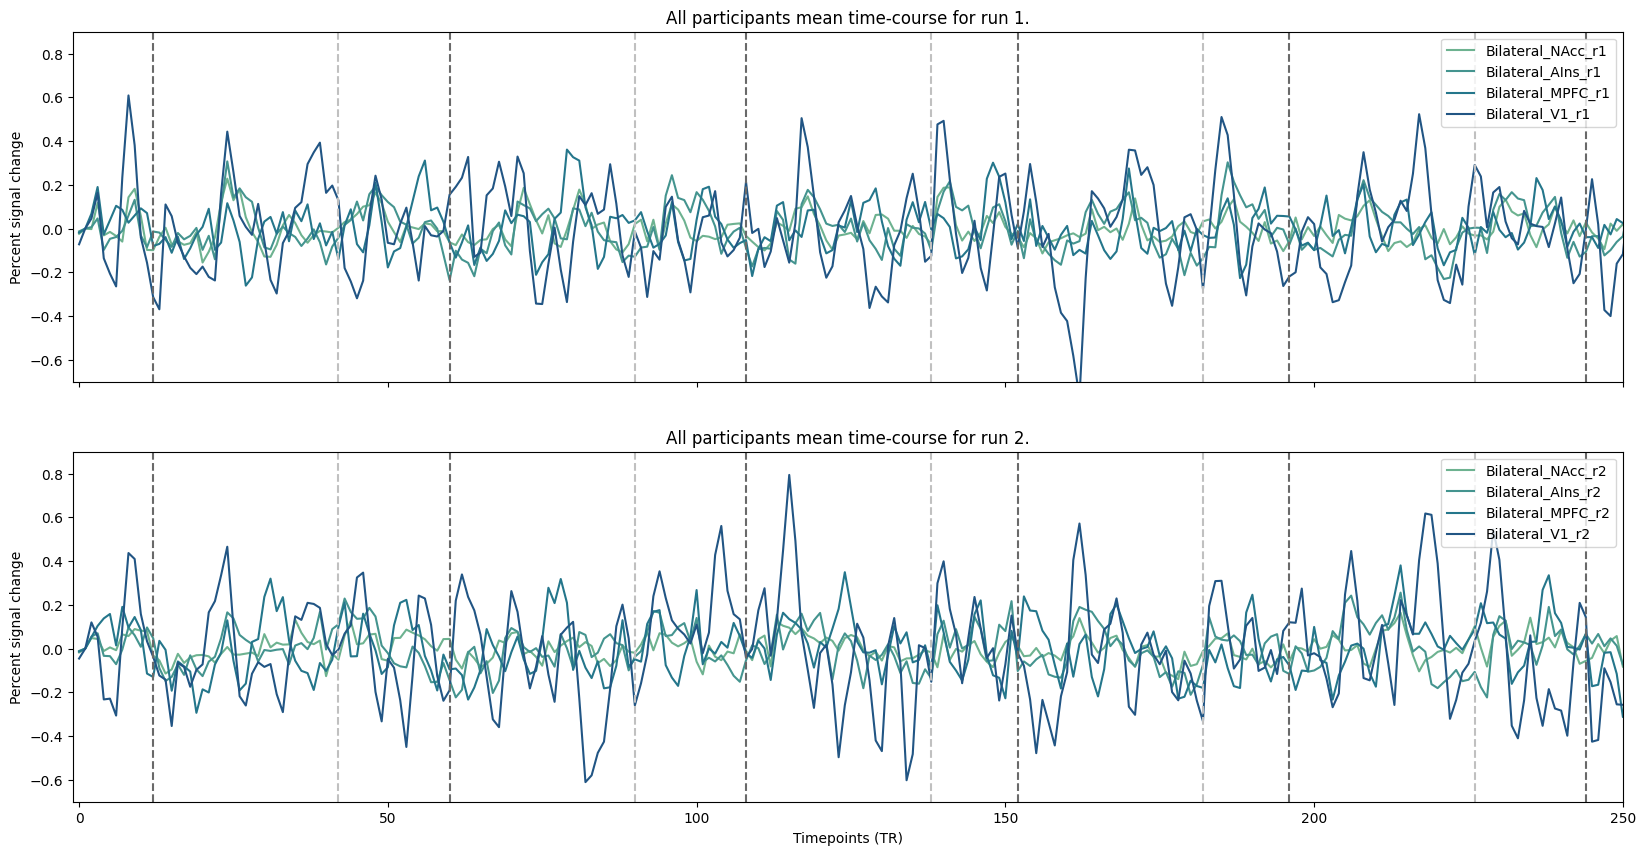

In [47]:
# Sanity check: Check whether V1 is coherently activated with AIM ROI. 

r1_onsets = [12, 60.0, 108.0, 152.0, 196.0, 244.0, 288.0, 332.0, 376.0, 420.0, 468.0, 512.0, 560.0, 608.0, 656.0, 700.0]
r1_offsets = [42, 90.0, 138.0, 182.0, 226.0, 274.0, 318.0, 362.0, 406.0, 450.0, 498.0, 542.0, 590.0, 638.0, 686.0, 730.0]

r2_onsets = [12, 60.0, 108.0, 152.0, 196.0, 244.0, 288.0, 332.0, 376.0, 420.0, 468.0, 512.0, 560.0, 608.0, 656.0, 700.0]
r2_offsets = [42, 90.0, 138.0, 182.0, 226.0, 274.0, 318.0, 362.0, 406.0, 450.0, 498.0, 542.0, 590.0, 638.0, 686.0, 730.0]

# Concat all dataframes into one.
bNAcc_avg_raw_r1_df = all_subjects_NAcc_raw_df[(all_subjects_NAcc_raw_df["ROI"] == "Bilateral_NAcc_r1")]
bAIns_avg_raw_r1_df = all_subjects_AIns_raw_df[(all_subjects_AIns_raw_df["ROI"] == "Bilateral_AIns_r1")]
bMPFC_avg_raw_r1_df = all_subjects_MPFC_raw_df[(all_subjects_MPFC_raw_df["ROI"] == "Bilateral_MPFC_r1")]
bV1_avg_raw_r1_df = all_subjects_V1_raw_df[(all_subjects_V1_raw_df["ROI"] == "Bilateral_V1_r1")]

bNAcc_avg_raw_r2_df = all_subjects_NAcc_raw_df[(all_subjects_NAcc_raw_df["ROI"] == "Bilateral_NAcc_r2")]
bAIns_avg_raw_r2_df = all_subjects_AIns_raw_df[(all_subjects_AIns_raw_df["ROI"] == "Bilateral_AIns_r2")]
bMPFC_avg_raw_r2_df = all_subjects_MPFC_raw_df[(all_subjects_MPFC_raw_df["ROI"] == "Bilateral_MPFC_r2")]
bV1_avg_raw_r2_df = all_subjects_V1_raw_df[(all_subjects_V1_raw_df["ROI"] == "Bilateral_V1_r2")]

AIM_V1_ROIs_avg_r1_df = pd.concat([bNAcc_avg_raw_r1_df, bAIns_avg_raw_r1_df, bMPFC_avg_raw_r1_df, bV1_avg_raw_r1_df], axis=0, ignore_index=True)
AIM_V1_ROIs_avg_r2_df = pd.concat([bNAcc_avg_raw_r2_df, bAIns_avg_raw_r2_df, bMPFC_avg_raw_r2_df, bV1_avg_raw_r2_df], axis=0, ignore_index=True)
AIM_V1_ROIs_avg_r1_df = AIM_V1_ROIs_avg_r1_df.dropna()
AIM_V1_ROIs_avg_r2_df = AIM_V1_ROIs_avg_r2_df.dropna()

fig, axs = plt.subplots(2, 1, figsize=(20, 10), sharex=True)

sns.lineplot(data=AIM_V1_ROIs_avg_r1_df, x="TR", y="Signal", hue="ROI",
            legend="brief", ax=axs[0], errorbar="se", palette="crest")
axs[0].set_ylim(-.7, .9)
axs[0].set_xlim(-1, 250)
for i in range(len(r1_onsets)):
    axs[0].axvline(x = r1_onsets[i], color = 'dimgray', lw=1.5, linestyle='dashed')
    axs[0].axvline(x = r1_offsets[i], color = 'silver', lw=1.5, linestyle='dashed')
axs[0].legend(loc='upper right')
axs[0].set_ylabel('Percent signal change')
axs[0].set_xlabel('Timepoints (TR)')
axs[0].set_title("All participants mean time-course for run 1.")

sns.lineplot(data=AIM_V1_ROIs_avg_r2_df, x="TR", y="Signal", hue="ROI",
            legend="brief", ax=axs[1], errorbar="se", palette="crest")
axs[1].set_ylim(-.7, .9)
axs[1].set_xlim(-1, 250)
for i in range(len(r2_onsets)):
    axs[1].axvline(x = r2_onsets[i], color = 'dimgray', lw=1.5, linestyle='dashed')
    axs[1].axvline(x = r2_offsets[i], color = 'silver', lw=1.5, linestyle='dashed') 
axs[1].legend(loc='upper right')
axs[1].set_ylabel('Percent signal change')
axs[1].set_xlabel('Timepoints (TR)')
axs[1].set_title("All participants mean time-course for run 2.")


In [48]:
# Okay, the above code will get the pearson code per TR per ROI per trailer.
trailer_keys = ['rh6', 'rc2', 'uh1', 'rc9', 'rh2', 'uc4', 'rh1', 'rc6',
                'rh9', 'rc11', 'uh2', 'uc1', 'rh3', 'rc12', 'rh11', 'rc5',
                'rc3', 'rh12', 'rc1', 'rh7', 'rc8', 'rh10', 'uc3', 'rh4',
                'rc4', 'rh5', 'uc2', 'rh8', 'rc10', 'uh3', 'rc7', 'uh4']

# trailer -> Scores -> ROI -> Corrs per TR
NAcc_TR_correlations = {}
AIns_TR_correlations = {}
MPFC_TR_correlations = {}

# trailer -> Scores & ROI -> TRs (TR=1 for all participants)
Trailer_TR_Scores_dict = {}

for trailer_id in range(len(trailer_keys)):

    # Create new participant list with only the participants that have the current trailer.
    participants_with_trailer = [d for d in participant_dictionaries if trailer_keys[trailer_id] in participant_dictionaries[d]]

    NAcc_current_corrs = {}
    AIns_current_corrs = {}
    MPFC_current_corrs = {}

    current_trailer_dict = {}

    NAcc_TR = {}
    AIns_TR = {}
    MPFC_TR = {}

    current_trailer_w_scores = np.zeros(len(participants_with_trailer))
    current_trailer_pa_scores = np.zeros(len(participants_with_trailer))
    current_trailer_na_scores = np.zeros(len(participants_with_trailer))

    current_trailer_TRs = np.zeros(len(participants_with_trailer))

    # Get the watch, arousal, and feel scores for each participant for the current trailer.
    for id in range(len(participants_with_trailer)):
        
        current_trailer_w_scores[id] = participants_events[participants_with_trailer[id]].loc[participants_events[participants_with_trailer[id]]["Trailer"] == trailer_keys[trailer_id]]["W_score_scaled"]
        current_trailer_pa_scores[id] = participants_events[participants_with_trailer[id]].loc[participants_events[participants_with_trailer[id]]["Trailer"] == trailer_keys[trailer_id]]["Pos_arousal_scaled"]
        current_trailer_na_scores[id] = participants_events[participants_with_trailer[id]].loc[participants_events[participants_with_trailer[id]]["Trailer"] == trailer_keys[trailer_id]]["Neg_arousal_scaled"] 

    # Loop through each TR for the current trailer.
    for tr_id in range(15):

        NAcc_current_trailer_TRs_array = np.zeros(len(participants_with_trailer))
        AIns_current_trailer_TRs_array = np.zeros(len(participants_with_trailer))
        MPFC_current_trailer_TRs_array = np.zeros(len(participants_with_trailer))

        # Loop through each participant for each TR for the current trailer.
        for id2 in range(len(participants_with_trailer)):

            current_sub2 = str(participants_with_trailer[id2])

            NAcc_current_trailer_TRs_array[id2] = all_subjects_NAcc_timecourse[trailer_keys[trailer_id]][current_sub2]["Bilateral_NAcc"][tr_id]
            AIns_current_trailer_TRs_array[id2] = all_subjects_AIns_timecourse[trailer_keys[trailer_id]][current_sub2]["Bilateral_AIns"][tr_id]
            MPFC_current_trailer_TRs_array[id2] = all_subjects_MPFC_timecourse[trailer_keys[trailer_id]][current_sub2]["Bilateral_MPFC"][tr_id]

        # Compute the correlation between the scores and the timecourse for the current TR.
        NAcc_current_corrs[str("TR_" + str(tr_id) + "_w")] = pearsonr(NAcc_current_trailer_TRs_array, current_trailer_w_scores)
        AIns_current_corrs[str("TR_" + str(tr_id) + "_w")] = pearsonr(AIns_current_trailer_TRs_array, current_trailer_w_scores)
        MPFC_current_corrs[str("TR_" + str(tr_id) + "_w")] = pearsonr(MPFC_current_trailer_TRs_array, current_trailer_w_scores) 

        NAcc_current_corrs[str("TR_" + str(tr_id) + "_pa")] = pearsonr(NAcc_current_trailer_TRs_array, current_trailer_pa_scores)
        AIns_current_corrs[str("TR_" + str(tr_id) + "_pa")] = pearsonr(AIns_current_trailer_TRs_array, current_trailer_pa_scores)
        MPFC_current_corrs[str("TR_" + str(tr_id) + "_pa")] = pearsonr(MPFC_current_trailer_TRs_array, current_trailer_pa_scores)

        NAcc_current_corrs[str("TR_" + str(tr_id) + "_na")] = pearsonr(NAcc_current_trailer_TRs_array, current_trailer_na_scores)
        AIns_current_corrs[str("TR_" + str(tr_id) + "_na")] = pearsonr(AIns_current_trailer_TRs_array, current_trailer_na_scores)
        MPFC_current_corrs[str("TR_" + str(tr_id) + "_na")] = pearsonr(MPFC_current_trailer_TRs_array, current_trailer_na_scores) 
                    
        NAcc_TR[str("TR_" + str(tr_id))] = NAcc_current_trailer_TRs_array
        AIns_TR[str("TR_" + str(tr_id))] = AIns_current_trailer_TRs_array
        MPFC_TR[str("TR_" + str(tr_id))] = MPFC_current_trailer_TRs_array

    # Add code to compute correlatation accross trailer segments(onset, middle, offset, and whole).
    NAcc_current_trailer_onset_array = np.zeros(len(participants_with_trailer))
    AIns_current_trailer_onset_array = np.zeros(len(participants_with_trailer))
    MPFC_current_trailer_onset_array = np.zeros(len(participants_with_trailer))

    NAcc_current_trailer_offset_array = np.zeros(len(participants_with_trailer))
    AIns_current_trailer_offset_array = np.zeros(len(participants_with_trailer))
    MPFC_current_trailer_offset_array = np.zeros(len(participants_with_trailer))

    NAcc_current_trailer_middle_array = np.zeros(len(participants_with_trailer))
    AIns_current_trailer_middle_array = np.zeros(len(participants_with_trailer))
    MPFC_current_trailer_middle_array = np.zeros(len(participants_with_trailer))

    NAcc_current_trailer_whole_array = np.zeros(len(participants_with_trailer))
    AIns_current_trailer_whole_array = np.zeros(len(participants_with_trailer))
    MPFC_current_trailer_whole_array = np.zeros(len(participants_with_trailer))
    
    # Loop through each participant the current trailer.
    for sub_id3 in range(len(participants_with_trailer)):

        current_sub3 = str(participants_with_trailer[sub_id3])

        # Compute the mean timecourse for the onset, middle, and offset of the current trailer.
        NAcc_current_trailer_onset_array[sub_id3] = all_subjects_NAcc_timecourse[trailer_keys[trailer_id]][current_sub3]["Bilateral_NAcc"][0:5].mean()
        AIns_current_trailer_onset_array[sub_id3] = all_subjects_AIns_timecourse[trailer_keys[trailer_id]][current_sub3]["Bilateral_AIns"][0:5].mean()
        MPFC_current_trailer_onset_array[sub_id3] = all_subjects_MPFC_timecourse[trailer_keys[trailer_id]][current_sub3]["Bilateral_MPFC"][0:5].mean()

        NAcc_current_trailer_middle_array[sub_id3] = all_subjects_NAcc_timecourse[trailer_keys[trailer_id]][current_sub3]["Bilateral_NAcc"][5:10].mean()
        AIns_current_trailer_middle_array[sub_id3] = all_subjects_AIns_timecourse[trailer_keys[trailer_id]][current_sub3]["Bilateral_AIns"][5:10].mean()
        MPFC_current_trailer_middle_array[sub_id3] = all_subjects_MPFC_timecourse[trailer_keys[trailer_id]][current_sub3]["Bilateral_MPFC"][5:10].mean()

        NAcc_current_trailer_offset_array[sub_id3] = all_subjects_NAcc_timecourse[trailer_keys[trailer_id]][current_sub3]["Bilateral_NAcc"][10:15].mean()
        AIns_current_trailer_offset_array[sub_id3] = all_subjects_AIns_timecourse[trailer_keys[trailer_id]][current_sub3]["Bilateral_AIns"][10:15].mean()
        MPFC_current_trailer_offset_array[sub_id3] = all_subjects_MPFC_timecourse[trailer_keys[trailer_id]][current_sub3]["Bilateral_MPFC"][10:15].mean()

        NAcc_current_trailer_whole_array[sub_id3] = all_subjects_NAcc_timecourse[trailer_keys[trailer_id]][current_sub3]["Bilateral_NAcc"].mean()
        AIns_current_trailer_whole_array[sub_id3] = all_subjects_AIns_timecourse[trailer_keys[trailer_id]][current_sub3]["Bilateral_AIns"].mean()
        MPFC_current_trailer_whole_array[sub_id3] = all_subjects_MPFC_timecourse[trailer_keys[trailer_id]][current_sub3]["Bilateral_MPFC"].mean()

    # Compute the correlation between the scores and the timecourse for the current TR.
    NAcc_current_corrs[str("Onset_w")] = pearsonr(NAcc_current_trailer_onset_array, current_trailer_w_scores)
    AIns_current_corrs[str("Onset_w")] = pearsonr(AIns_current_trailer_onset_array, current_trailer_w_scores)
    MPFC_current_corrs[str("Onset_w")] = pearsonr(MPFC_current_trailer_onset_array, current_trailer_w_scores)
    NAcc_current_corrs[str("Middle_w")] = pearsonr(NAcc_current_trailer_middle_array, current_trailer_w_scores)
    AIns_current_corrs[str("Middle_w")] = pearsonr(AIns_current_trailer_middle_array, current_trailer_w_scores)
    MPFC_current_corrs[str("Middle_w")] = pearsonr(MPFC_current_trailer_middle_array, current_trailer_w_scores)
    NAcc_current_corrs[str("Offset_w")] = pearsonr(NAcc_current_trailer_offset_array, current_trailer_w_scores)
    AIns_current_corrs[str("Offset_w")] = pearsonr(AIns_current_trailer_offset_array, current_trailer_w_scores)
    MPFC_current_corrs[str("Offset_w")] = pearsonr(MPFC_current_trailer_offset_array, current_trailer_w_scores)
    NAcc_current_corrs[str("Whole_w")] = pearsonr(NAcc_current_trailer_whole_array, current_trailer_w_scores)
    AIns_current_corrs[str("Whole_w")] = pearsonr(AIns_current_trailer_whole_array, current_trailer_w_scores)
    MPFC_current_corrs[str("Whole_w")] = pearsonr(MPFC_current_trailer_whole_array, current_trailer_w_scores)

    NAcc_current_corrs[str("Onset_pa")] = pearsonr(NAcc_current_trailer_onset_array, current_trailer_pa_scores)
    AIns_current_corrs[str("Onset_pa")] = pearsonr(AIns_current_trailer_onset_array, current_trailer_pa_scores)
    MPFC_current_corrs[str("Onset_pa")] = pearsonr(MPFC_current_trailer_onset_array, current_trailer_pa_scores)
    NAcc_current_corrs[str("Middle_pa")] = pearsonr(NAcc_current_trailer_middle_array, current_trailer_pa_scores)
    AIns_current_corrs[str("Middle_pa")] = pearsonr(AIns_current_trailer_middle_array, current_trailer_pa_scores)
    MPFC_current_corrs[str("Middle_pa")] = pearsonr(MPFC_current_trailer_middle_array, current_trailer_pa_scores)
    NAcc_current_corrs[str("Offset_pa")] = pearsonr(NAcc_current_trailer_offset_array, current_trailer_pa_scores)
    AIns_current_corrs[str("Offset_pa")] = pearsonr(AIns_current_trailer_offset_array, current_trailer_pa_scores)
    MPFC_current_corrs[str("Offset_pa")] = pearsonr(MPFC_current_trailer_offset_array, current_trailer_pa_scores)
    NAcc_current_corrs[str("Whole_pa")] = pearsonr(NAcc_current_trailer_whole_array, current_trailer_pa_scores)
    AIns_current_corrs[str("Whole_pa")] = pearsonr(AIns_current_trailer_whole_array, current_trailer_pa_scores)
    MPFC_current_corrs[str("Whole_pa")] = pearsonr(MPFC_current_trailer_whole_array, current_trailer_pa_scores)

    NAcc_current_corrs[str("Onset_na")] = pearsonr(NAcc_current_trailer_onset_array, current_trailer_na_scores)
    AIns_current_corrs[str("Onset_na")] = pearsonr(AIns_current_trailer_onset_array, current_trailer_na_scores)
    MPFC_current_corrs[str("Onset_na")] = pearsonr(MPFC_current_trailer_onset_array, current_trailer_na_scores)
    NAcc_current_corrs[str("Middle_na")] = pearsonr(NAcc_current_trailer_middle_array, current_trailer_na_scores)
    AIns_current_corrs[str("Middle_na")] = pearsonr(AIns_current_trailer_middle_array, current_trailer_na_scores)
    MPFC_current_corrs[str("Middle_na")] = pearsonr(MPFC_current_trailer_middle_array, current_trailer_na_scores)
    NAcc_current_corrs[str("Offset_na")] = pearsonr(NAcc_current_trailer_offset_array, current_trailer_na_scores)
    AIns_current_corrs[str("Offset_na")] = pearsonr(AIns_current_trailer_offset_array, current_trailer_na_scores)
    MPFC_current_corrs[str("Offset_na")] = pearsonr(MPFC_current_trailer_offset_array, current_trailer_na_scores)
    NAcc_current_corrs[str("Whole_na")] = pearsonr(NAcc_current_trailer_whole_array, current_trailer_na_scores)
    AIns_current_corrs[str("Whole_na")] = pearsonr(AIns_current_trailer_whole_array, current_trailer_na_scores)
    MPFC_current_corrs[str("Whole_na")] = pearsonr(MPFC_current_trailer_whole_array, current_trailer_na_scores)

    current_trailer_dict["W_score_scaled"] = current_trailer_w_scores
    current_trailer_dict["Pos_arousal_scaled"] = current_trailer_pa_scores
    current_trailer_dict["Neg_arousal_scaled"] = current_trailer_na_scores
    current_trailer_dict["NAcc_TR"] = NAcc_TR
    current_trailer_dict["AIns_TR"] = AIns_TR
    current_trailer_dict["MPFC_TR"] = MPFC_TR

    Trailer_TR_Scores_dict[trailer_keys[trailer_id]] = current_trailer_dict

    # Store the trailer correlations in higher dict.  
    NAcc_TR_correlations[trailer_keys[trailer_id]] = NAcc_current_corrs
    AIns_TR_correlations[trailer_keys[trailer_id]] = AIns_current_corrs
    MPFC_TR_correlations[trailer_keys[trailer_id]] = MPFC_current_corrs

In [49]:
# Get correlation across all comedy trailers for each TR. 
# See which TR is most correlated with the scores.

comedy_keys = ['rc1', 'rc2', 'rc3', 'rc4', 'rc5', 'rc6', 'rc7', 'rc8', 'rc9', 'rc10', 'rc11', 'rc12',
               'uc1', 'uc2', 'uc3', 'uc4']

Comedy_NAccTRs_cors_dict = {}
Comedy_AInsTRs_cors_dict = {}
Comedy_MPFCTRs_cors_dict = {}

# Create list to store each trailer TR X values for each participant.
C_NAcc_TR1 = []
C_NAcc_TR2 = []
C_NAcc_TR3 = []
C_NAcc_TR4 = []
C_NAcc_TR5 = []
C_NAcc_TR6 = []
C_NAcc_TR7 = []
C_NAcc_TR8 = []
C_NAcc_TR9 = []
C_NAcc_TR10 = []
C_NAcc_TR11 = []
C_NAcc_TR12 = []
C_NAcc_TR13 = []
C_NAcc_TR14 = []
C_NAcc_TR15 = []
C_NAcc_onset = []
C_NAcc_middle = []
C_NAcc_offset = []
C_NAcc_whole = []

C_AIns_TR1 = []
C_AIns_TR2 = []
C_AIns_TR3 = []
C_AIns_TR4 = []
C_AIns_TR5 = []
C_AIns_TR6 = []
C_AIns_TR7 = []
C_AIns_TR8 = []
C_AIns_TR9 = []
C_AIns_TR10 = []
C_AIns_TR11 = []
C_AIns_TR12 = []
C_AIns_TR13 = []
C_AIns_TR14 = []
C_AIns_TR15 = []
C_AIns_onset = []
C_AIns_middle = []
C_AIns_offset = []
C_AIns_whole = []

C_MPFC_TR1 = []
C_MPFC_TR2 = []
C_MPFC_TR3 = []
C_MPFC_TR4 = []
C_MPFC_TR5 = []
C_MPFC_TR6 = []
C_MPFC_TR7 = []
C_MPFC_TR8 = []
C_MPFC_TR9 = []
C_MPFC_TR10 = []
C_MPFC_TR11 = []
C_MPFC_TR12 = []
C_MPFC_TR13 = []
C_MPFC_TR14 = []
C_MPFC_TR15 = []
C_MPFC_onset = []
C_MPFC_middle = []
C_MPFC_offset = []
C_MPFC_whole = []

# Create lists to store the scores for each participant for the current trailer.
C_W_scores = []
C_PA_scores = []
C_NA_scores = []

for trailer_id in range(len(comedy_keys)):

    # Create new participant list with only the participants that have the current trailer.
    participants_with_trailer = [d for d in participant_dictionaries if comedy_keys[trailer_id] in participant_dictionaries[d]]

    # Loop through each participant for each TR for the current trailer.
    for sub_id2 in range(len(participants_with_trailer)):

        current_sub = str(participants_with_trailer[sub_id2])

        # Append the current TR value for the current participant to the list.
        C_NAcc_TR1.append(all_subjects_NAcc_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_NAcc"][0])
        C_NAcc_TR2.append(all_subjects_NAcc_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_NAcc"][1])
        C_NAcc_TR3.append(all_subjects_NAcc_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_NAcc"][2])
        C_NAcc_TR4.append(all_subjects_NAcc_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_NAcc"][3])
        C_NAcc_TR5.append(all_subjects_NAcc_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_NAcc"][4])
        C_NAcc_TR6.append(all_subjects_NAcc_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_NAcc"][5])
        C_NAcc_TR7.append(all_subjects_NAcc_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_NAcc"][6])
        C_NAcc_TR8.append(all_subjects_NAcc_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_NAcc"][7])
        C_NAcc_TR9.append(all_subjects_NAcc_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_NAcc"][8])
        C_NAcc_TR10.append(all_subjects_NAcc_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_NAcc"][9])
        C_NAcc_TR11.append(all_subjects_NAcc_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_NAcc"][10])
        C_NAcc_TR12.append(all_subjects_NAcc_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_NAcc"][11])
        C_NAcc_TR13.append(all_subjects_NAcc_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_NAcc"][12])
        C_NAcc_TR14.append(all_subjects_NAcc_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_NAcc"][13])
        C_NAcc_TR15.append(all_subjects_NAcc_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_NAcc"][14])
        C_NAcc_onset.append(all_subjects_NAcc_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_NAcc"][0:5].mean())
        C_NAcc_middle.append(all_subjects_NAcc_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_NAcc"][5:10].mean())
        C_NAcc_offset.append(all_subjects_NAcc_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_NAcc"][10:15].mean())
        C_NAcc_whole.append(all_subjects_NAcc_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_NAcc"].mean())

        C_AIns_TR1.append(all_subjects_AIns_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_AIns"][0])
        C_AIns_TR2.append(all_subjects_AIns_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_AIns"][1])
        C_AIns_TR3.append(all_subjects_AIns_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_AIns"][2])
        C_AIns_TR4.append(all_subjects_AIns_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_AIns"][3])
        C_AIns_TR5.append(all_subjects_AIns_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_AIns"][4])
        C_AIns_TR6.append(all_subjects_AIns_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_AIns"][5])
        C_AIns_TR7.append(all_subjects_AIns_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_AIns"][6])
        C_AIns_TR8.append(all_subjects_AIns_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_AIns"][7])
        C_AIns_TR9.append(all_subjects_AIns_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_AIns"][8])
        C_AIns_TR10.append(all_subjects_AIns_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_AIns"][9])
        C_AIns_TR11.append(all_subjects_AIns_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_AIns"][10])
        C_AIns_TR12.append(all_subjects_AIns_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_AIns"][11])
        C_AIns_TR13.append(all_subjects_AIns_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_AIns"][12])
        C_AIns_TR14.append(all_subjects_AIns_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_AIns"][13])
        C_AIns_TR15.append(all_subjects_AIns_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_AIns"][14])
        C_AIns_onset.append(all_subjects_AIns_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_AIns"][0:5].mean())
        C_AIns_middle.append(all_subjects_AIns_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_AIns"][5:10].mean())
        C_AIns_offset.append(all_subjects_AIns_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_AIns"][10:15].mean())
        C_AIns_whole.append(all_subjects_AIns_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_AIns"].mean())

        C_MPFC_TR1.append(all_subjects_MPFC_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_MPFC"][0])
        C_MPFC_TR2.append(all_subjects_MPFC_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_MPFC"][1])
        C_MPFC_TR3.append(all_subjects_MPFC_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_MPFC"][2])
        C_MPFC_TR4.append(all_subjects_MPFC_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_MPFC"][3])
        C_MPFC_TR5.append(all_subjects_MPFC_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_MPFC"][4])
        C_MPFC_TR6.append(all_subjects_MPFC_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_MPFC"][5])
        C_MPFC_TR7.append(all_subjects_MPFC_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_MPFC"][6])
        C_MPFC_TR8.append(all_subjects_MPFC_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_MPFC"][7])
        C_MPFC_TR9.append(all_subjects_MPFC_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_MPFC"][8])
        C_MPFC_TR10.append(all_subjects_MPFC_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_MPFC"][9])
        C_MPFC_TR11.append(all_subjects_MPFC_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_MPFC"][10])
        C_MPFC_TR12.append(all_subjects_MPFC_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_MPFC"][11])
        C_MPFC_TR13.append(all_subjects_MPFC_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_MPFC"][12])
        C_MPFC_TR14.append(all_subjects_MPFC_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_MPFC"][13])
        C_MPFC_TR15.append(all_subjects_MPFC_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_MPFC"][14])
        C_MPFC_onset.append(all_subjects_MPFC_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_MPFC"][0:5].mean())
        C_MPFC_middle.append(all_subjects_MPFC_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_MPFC"][5:10].mean())
        C_MPFC_offset.append(all_subjects_MPFC_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_MPFC"][10:15].mean())
        C_MPFC_whole.append(all_subjects_MPFC_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_MPFC"].mean())

# Store all list in bigger list for each ROI. 
C_NAcc_TRs = [C_NAcc_TR1, C_NAcc_TR2, C_NAcc_TR3, C_NAcc_TR4, C_NAcc_TR5, C_NAcc_TR6, C_NAcc_TR7, C_NAcc_TR8, C_NAcc_TR9, C_NAcc_TR10, C_NAcc_TR11, C_NAcc_TR12, C_NAcc_TR13, C_NAcc_TR14, C_NAcc_TR15]
C_AIns_TRs = [C_AIns_TR1, C_AIns_TR2, C_AIns_TR3, C_AIns_TR4, C_AIns_TR5, C_AIns_TR6, C_AIns_TR7, C_AIns_TR8, C_AIns_TR9, C_AIns_TR10, C_AIns_TR11, C_AIns_TR12, C_AIns_TR13, C_AIns_TR14, C_AIns_TR15]
C_MPFC_TRs = [C_MPFC_TR1, C_MPFC_TR2, C_MPFC_TR3, C_MPFC_TR4, C_MPFC_TR5, C_MPFC_TR6, C_MPFC_TR7, C_MPFC_TR8, C_MPFC_TR9, C_MPFC_TR10, C_MPFC_TR11, C_MPFC_TR12, C_MPFC_TR13, C_MPFC_TR14, C_MPFC_TR15]

# Get W, PA, and NA scores. 
C_W_scores = np.zeros(len(C_NAcc_TR1))
C_PA_scores = np.zeros(len(C_NAcc_TR1))
C_NA_scores = np.zeros(len(C_NAcc_TR1))

for trailer_id in range(len(comedy_keys)):

    # Create new participant list with only the participants that have the current trailer.
    participants_with_trailer = [d for d in participant_dictionaries if comedy_keys[trailer_id] in participant_dictionaries[d]]

    # Get the watch, arousal, and feel scores for each participant for the current trailer.
    for sub_id in range(len(participants_with_trailer)):
        
        C_W_scores[sub_id] = participants_events[participants_with_trailer[sub_id]].loc[participants_events[participants_with_trailer[sub_id]]["Trailer"] == comedy_keys[trailer_id]]["W_score_scaled"]
        C_PA_scores[sub_id] = participants_events[participants_with_trailer[sub_id]].loc[participants_events[participants_with_trailer[sub_id]]["Trailer"] == comedy_keys[trailer_id]]["Pos_arousal_scaled"]
        C_NA_scores[sub_id] = participants_events[participants_with_trailer[sub_id]].loc[participants_events[participants_with_trailer[sub_id]]["Trailer"] == comedy_keys[trailer_id]]["Neg_arousal_scaled"]

for tr_id in range(15):
    
    # Compute the correlation between the scores and the timecourse for the current TR.
    Comedy_NAccTRs_cors_dict[str("TR_" + str(tr_id) + "_w")] = pearsonr(C_NAcc_TRs[tr_id], C_W_scores)
    Comedy_AInsTRs_cors_dict[str("TR_" + str(tr_id) + "_w")] = pearsonr(C_AIns_TRs[tr_id], C_W_scores)
    Comedy_MPFCTRs_cors_dict[str("TR_" + str(tr_id) + "_w")] = pearsonr(C_MPFC_TRs[tr_id], C_W_scores)

    Comedy_NAccTRs_cors_dict[str("TR_" + str(tr_id) + "_pa")] = pearsonr(C_NAcc_TRs[tr_id], C_PA_scores)
    Comedy_AInsTRs_cors_dict[str("TR_" + str(tr_id) + "_pa")] = pearsonr(C_AIns_TRs[tr_id], C_PA_scores)
    Comedy_MPFCTRs_cors_dict[str("TR_" + str(tr_id) + "_pa")] = pearsonr(C_MPFC_TRs[tr_id], C_PA_scores)

    Comedy_NAccTRs_cors_dict[str("TR_" + str(tr_id) + "_na")] = pearsonr(C_NAcc_TRs[tr_id], C_NA_scores)
    Comedy_AInsTRs_cors_dict[str("TR_" + str(tr_id) + "_na")] = pearsonr(C_AIns_TRs[tr_id], C_NA_scores)
    Comedy_MPFCTRs_cors_dict[str("TR_" + str(tr_id) + "_na")] = pearsonr(C_MPFC_TRs[tr_id], C_NA_scores)

# Store time segments in lists.
C_NAcc_seg = [C_NAcc_onset, C_NAcc_middle, C_NAcc_offset, C_NAcc_whole]
C_AIns_seg = [C_AIns_onset, C_AIns_middle, C_AIns_offset, C_AIns_whole]
C_MPFC_seg = [C_MPFC_onset, C_MPFC_middle, C_MPFC_offset, C_MPFC_whole]
Seg_labels = ["Onset", "Middle", "Offset", "Whole"]

for seg_id in range(4):
        
    # Compute the correlation between the scores and the timecourse for the current TR.
    Comedy_NAccTRs_cors_dict[str(Seg_labels[seg_id] + "_w")] = pearsonr(C_NAcc_seg[seg_id], C_W_scores)
    Comedy_AInsTRs_cors_dict[str(Seg_labels[seg_id] + "_w")] = pearsonr(C_AIns_seg[seg_id], C_W_scores)
    Comedy_MPFCTRs_cors_dict[str(Seg_labels[seg_id] + "_w")] = pearsonr(C_MPFC_seg[seg_id], C_W_scores)
    
    Comedy_NAccTRs_cors_dict[str(Seg_labels[seg_id] + "_pa")] = pearsonr(C_NAcc_seg[seg_id], C_PA_scores)
    Comedy_AInsTRs_cors_dict[str(Seg_labels[seg_id] + "_pa")] = pearsonr(C_AIns_seg[seg_id], C_PA_scores)
    Comedy_MPFCTRs_cors_dict[str(Seg_labels[seg_id] + "_pa")] = pearsonr(C_MPFC_seg[seg_id], C_PA_scores)
    
    Comedy_NAccTRs_cors_dict[str(Seg_labels[seg_id] + "_na")] = pearsonr(C_NAcc_seg[seg_id], C_NA_scores)
    Comedy_AInsTRs_cors_dict[str(Seg_labels[seg_id] + "_na")] = pearsonr(C_AIns_seg[seg_id], C_NA_scores)
    Comedy_MPFCTRs_cors_dict[str(Seg_labels[seg_id] + "_na")] = pearsonr(C_MPFC_seg[seg_id], C_NA_scores)



In [50]:
# Get correlation across all horror trailers for each TR. 
# See which TR is most correlated with the scores.

horror_keys = ['rh1', 'rh2', 'rh3', 'rh4', 'rh5', 'rh6', 'rh7', 'rh8', 'rh9', 'rh10', 'rh11', 'rh12', 
               'uh1', 'uh2', 'uh3', 'uh4']

Horror_NAccTRs_cors_dict = {}
Horror_AInsTRs_cors_dict = {}
Horror_MPFCTRs_cors_dict = {}

# Create list to store each trailer TR X values for each participant.
H_NAcc_TR1 = []
H_NAcc_TR2 = []
H_NAcc_TR3 = []
H_NAcc_TR4 = []
H_NAcc_TR5 = []
H_NAcc_TR6 = []
H_NAcc_TR7 = []
H_NAcc_TR8 = []
H_NAcc_TR9 = []
H_NAcc_TR10 = []
H_NAcc_TR11 = []
H_NAcc_TR12 = []
H_NAcc_TR13 = []
H_NAcc_TR14 = []
H_NAcc_TR15 = []
H_NAcc_Onset = []
H_NAcc_Middle = []
H_NAcc_Offset = []
H_NAcc_Whole = []

H_AIns_TR1 = []
H_AIns_TR2 = []
H_AIns_TR3 = []
H_AIns_TR4 = []
H_AIns_TR5 = []
H_AIns_TR6 = []
H_AIns_TR7 = []
H_AIns_TR8 = []
H_AIns_TR9 = []
H_AIns_TR10 = []
H_AIns_TR11 = []
H_AIns_TR12 = []
H_AIns_TR13 = []
H_AIns_TR14 = []
H_AIns_TR15 = []
H_AIns_Onset = []
H_AIns_Middle = []
H_AIns_Offset = []
H_AIns_Whole = []

H_MPFC_TR1 = []
H_MPFC_TR2 = []
H_MPFC_TR3 = []
H_MPFC_TR4 = []
H_MPFC_TR5 = []
H_MPFC_TR6 = []
H_MPFC_TR7 = []
H_MPFC_TR8 = []
H_MPFC_TR9 = []
H_MPFC_TR10 = []
H_MPFC_TR11 = []
H_MPFC_TR12 = []
H_MPFC_TR13 = []
H_MPFC_TR14 = []
H_MPFC_TR15 = []
H_MPFC_Onset = []
H_MPFC_Middle = []
H_MPFC_Offset = []
H_MPFC_Whole = []

# Create lists to store the scores for each participant for the current trailer.
H_W_scores = []
H_PA_scores = []
H_NA_scores = []

for trailer_id in range(len(horror_keys)):

    # Create new participant list with only the participants that have the current trailer.
    participants_with_trailer = [d for d in participant_dictionaries if horror_keys[trailer_id] in participant_dictionaries[d]]

    # Loop through each participant for each TR for the current trailer.
    for sub_id2 in range(len(participants_with_trailer)):

        current_sub = str(participants_with_trailer[sub_id2])

        # Append the current TR value for the current participant to the list.
        H_NAcc_TR1.append(all_subjects_NAcc_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_NAcc"][0])
        H_NAcc_TR2.append(all_subjects_NAcc_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_NAcc"][1])
        H_NAcc_TR3.append(all_subjects_NAcc_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_NAcc"][2])
        H_NAcc_TR4.append(all_subjects_NAcc_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_NAcc"][3])
        H_NAcc_TR5.append(all_subjects_NAcc_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_NAcc"][4])
        H_NAcc_TR6.append(all_subjects_NAcc_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_NAcc"][5])
        H_NAcc_TR7.append(all_subjects_NAcc_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_NAcc"][6])
        H_NAcc_TR8.append(all_subjects_NAcc_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_NAcc"][7])
        H_NAcc_TR9.append(all_subjects_NAcc_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_NAcc"][8])
        H_NAcc_TR10.append(all_subjects_NAcc_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_NAcc"][9])
        H_NAcc_TR11.append(all_subjects_NAcc_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_NAcc"][10])
        H_NAcc_TR12.append(all_subjects_NAcc_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_NAcc"][11])
        H_NAcc_TR13.append(all_subjects_NAcc_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_NAcc"][12])
        H_NAcc_TR14.append(all_subjects_NAcc_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_NAcc"][13])
        H_NAcc_TR15.append(all_subjects_NAcc_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_NAcc"][14])
        H_NAcc_Onset.append(all_subjects_NAcc_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_NAcc"][0:5].mean())
        H_NAcc_Middle.append(all_subjects_NAcc_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_NAcc"][5:10].mean())
        H_NAcc_Offset.append(all_subjects_NAcc_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_NAcc"][10:15].mean())
        H_NAcc_Whole.append(all_subjects_NAcc_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_NAcc"].mean())

        H_AIns_TR1.append(all_subjects_AIns_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_AIns"][0])
        H_AIns_TR2.append(all_subjects_AIns_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_AIns"][1])
        H_AIns_TR3.append(all_subjects_AIns_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_AIns"][2])
        H_AIns_TR4.append(all_subjects_AIns_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_AIns"][3])
        H_AIns_TR5.append(all_subjects_AIns_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_AIns"][4])
        H_AIns_TR6.append(all_subjects_AIns_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_AIns"][5])
        H_AIns_TR7.append(all_subjects_AIns_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_AIns"][6])
        H_AIns_TR8.append(all_subjects_AIns_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_AIns"][7])
        H_AIns_TR9.append(all_subjects_AIns_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_AIns"][8])
        H_AIns_TR10.append(all_subjects_AIns_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_AIns"][9])
        H_AIns_TR11.append(all_subjects_AIns_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_AIns"][10])
        H_AIns_TR12.append(all_subjects_AIns_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_AIns"][11])
        H_AIns_TR13.append(all_subjects_AIns_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_AIns"][12])
        H_AIns_TR14.append(all_subjects_AIns_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_AIns"][13])
        H_AIns_TR15.append(all_subjects_AIns_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_AIns"][14])
        H_AIns_Onset.append(all_subjects_AIns_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_AIns"][0:5].mean())
        H_AIns_Middle.append(all_subjects_AIns_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_AIns"][5:10].mean())
        H_AIns_Offset.append(all_subjects_AIns_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_AIns"][10:15].mean())
        H_AIns_Whole.append(all_subjects_AIns_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_AIns"].mean())

        H_MPFC_TR1.append(all_subjects_MPFC_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_MPFC"][0])
        H_MPFC_TR2.append(all_subjects_MPFC_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_MPFC"][1])
        H_MPFC_TR3.append(all_subjects_MPFC_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_MPFC"][2])
        H_MPFC_TR4.append(all_subjects_MPFC_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_MPFC"][3])
        H_MPFC_TR5.append(all_subjects_MPFC_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_MPFC"][4])
        H_MPFC_TR6.append(all_subjects_MPFC_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_MPFC"][5])
        H_MPFC_TR7.append(all_subjects_MPFC_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_MPFC"][6])
        H_MPFC_TR8.append(all_subjects_MPFC_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_MPFC"][7])
        H_MPFC_TR9.append(all_subjects_MPFC_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_MPFC"][8])
        H_MPFC_TR10.append(all_subjects_MPFC_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_MPFC"][9])
        H_MPFC_TR11.append(all_subjects_MPFC_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_MPFC"][10])
        H_MPFC_TR12.append(all_subjects_MPFC_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_MPFC"][11])
        H_MPFC_TR13.append(all_subjects_MPFC_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_MPFC"][12])
        H_MPFC_TR14.append(all_subjects_MPFC_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_MPFC"][13])
        H_MPFC_TR15.append(all_subjects_MPFC_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_MPFC"][14])
        H_MPFC_Onset.append(all_subjects_MPFC_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_MPFC"][0:5].mean())
        H_MPFC_Middle.append(all_subjects_MPFC_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_MPFC"][5:10].mean())
        H_MPFC_Offset.append(all_subjects_MPFC_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_MPFC"][10:15].mean())
        H_MPFC_Whole.append(all_subjects_MPFC_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_MPFC"].mean())

# Store all list in bigger list for each ROI.
H_NAcc_TRs = [H_NAcc_TR1, H_NAcc_TR2, H_NAcc_TR3, H_NAcc_TR4, H_NAcc_TR5, H_NAcc_TR6, H_NAcc_TR7, H_NAcc_TR8, H_NAcc_TR9, H_NAcc_TR10, H_NAcc_TR11, H_NAcc_TR12, H_NAcc_TR13, H_NAcc_TR14, H_NAcc_TR15]
H_AIns_TRs = [H_AIns_TR1, H_AIns_TR2, H_AIns_TR3, H_AIns_TR4, H_AIns_TR5, H_AIns_TR6, H_AIns_TR7, H_AIns_TR8, H_AIns_TR9, H_AIns_TR10, H_AIns_TR11, H_AIns_TR12, H_AIns_TR13, H_AIns_TR14, H_AIns_TR15]
H_MPFC_TRs = [H_MPFC_TR1, H_MPFC_TR2, H_MPFC_TR3, H_MPFC_TR4, H_MPFC_TR5, H_MPFC_TR6, H_MPFC_TR7, H_MPFC_TR8, H_MPFC_TR9, H_MPFC_TR10, H_MPFC_TR11, H_MPFC_TR12, H_MPFC_TR13, H_MPFC_TR14, H_MPFC_TR15]

# Get W, PA, and NA scores.
H_W_scores = np.zeros(len(H_NAcc_TR1))
H_PA_scores = np.zeros(len(H_NAcc_TR1))
H_NA_scores = np.zeros(len(H_NAcc_TR1))

for trailer_id in range(len(horror_keys)):

    # Create new participant list with only the participants that have the current trailer.
    participants_with_trailer = [d for d in participant_dictionaries if horror_keys[trailer_id] in participant_dictionaries[d]]

    # Get the watch, arousal, and feel scores for each participant for the current trailer.
    for sub_id in range(len(participants_with_trailer)):
        
        H_W_scores[sub_id] = participants_events[participants_with_trailer[sub_id]].loc[participants_events[participants_with_trailer[sub_id]]["Trailer"] == horror_keys[trailer_id]]["W_score_scaled"]
        H_PA_scores[sub_id] = participants_events[participants_with_trailer[sub_id]].loc[participants_events[participants_with_trailer[sub_id]]["Trailer"] == horror_keys[trailer_id]]["Pos_arousal_scaled"]
        H_NA_scores[sub_id] = participants_events[participants_with_trailer[sub_id]].loc[participants_events[participants_with_trailer[sub_id]]["Trailer"] == horror_keys[trailer_id]]["Neg_arousal_scaled"]

for tr_id in range(15):

    # Compute the correlation between the scores and the timecourse for the current TR.
    Horror_NAccTRs_cors_dict[str("TR_" + str(tr_id) + "_w")] = pearsonr(H_NAcc_TRs[tr_id], H_W_scores)
    Horror_AInsTRs_cors_dict[str("TR_" + str(tr_id) + "_w")] = pearsonr(H_AIns_TRs[tr_id], H_W_scores)
    Horror_MPFCTRs_cors_dict[str("TR_" + str(tr_id) + "_w")] = pearsonr(H_MPFC_TRs[tr_id], H_W_scores)

    Horror_NAccTRs_cors_dict[str("TR_" + str(tr_id) + "_pa")] = pearsonr(H_NAcc_TRs[tr_id], H_PA_scores)
    Horror_AInsTRs_cors_dict[str("TR_" + str(tr_id) + "_pa")] = pearsonr(H_AIns_TRs[tr_id], H_PA_scores)
    Horror_MPFCTRs_cors_dict[str("TR_" + str(tr_id) + "_pa")] = pearsonr(H_MPFC_TRs[tr_id], H_PA_scores)

    Horror_NAccTRs_cors_dict[str("TR_" + str(tr_id) + "_na")] = pearsonr(H_NAcc_TRs[tr_id], H_NA_scores)
    Horror_AInsTRs_cors_dict[str("TR_" + str(tr_id) + "_na")] = pearsonr(H_AIns_TRs[tr_id], H_NA_scores)
    Horror_MPFCTRs_cors_dict[str("TR_" + str(tr_id) + "_na")] = pearsonr(H_MPFC_TRs[tr_id], H_NA_scores)

# Store time segments in lists.
H_NAcc_seg = [H_NAcc_Onset, H_NAcc_Middle, H_NAcc_Offset, H_NAcc_Whole]
H_AIns_seg = [H_AIns_Onset, H_AIns_Middle, H_AIns_Offset, H_AIns_Whole]
H_MPFC_seg = [H_MPFC_Onset, H_MPFC_Middle, H_MPFC_Offset, H_MPFC_Whole]

for seg_id in range(4):

    # Compute the correlation between the scores and the timecourse for the current TR.
    Horror_NAccTRs_cors_dict[str(Seg_labels[seg_id] + "_w")] = pearsonr(H_NAcc_seg[seg_id], H_W_scores)
    Horror_AInsTRs_cors_dict[str(Seg_labels[seg_id] + "_w")] = pearsonr(H_AIns_seg[seg_id], H_W_scores)
    Horror_MPFCTRs_cors_dict[str(Seg_labels[seg_id] + "_w")] = pearsonr(H_MPFC_seg[seg_id], H_W_scores)

    Horror_NAccTRs_cors_dict[str(Seg_labels[seg_id] + "_pa")] = pearsonr(H_NAcc_seg[seg_id], H_PA_scores)
    Horror_AInsTRs_cors_dict[str(Seg_labels[seg_id] + "_pa")] = pearsonr(H_AIns_seg[seg_id], H_PA_scores)
    Horror_MPFCTRs_cors_dict[str(Seg_labels[seg_id] + "_pa")] = pearsonr(H_MPFC_seg[seg_id], H_PA_scores)

    Horror_NAccTRs_cors_dict[str(Seg_labels[seg_id] + "_na")] = pearsonr(H_NAcc_seg[seg_id], H_NA_scores)
    Horror_AInsTRs_cors_dict[str(Seg_labels[seg_id] + "_na")] = pearsonr(H_AIns_seg[seg_id], H_NA_scores)
    Horror_MPFCTRs_cors_dict[str(Seg_labels[seg_id] + "_na")] = pearsonr(H_MPFC_seg[seg_id], H_NA_scores)


In [51]:
# Create dataframes, one with all time points from comedy trailers, 
# another with all time points from horror trailers.

all_subjects_NAcc_comedy_df = pd.DataFrame(columns=["Participant", "ROI", "Signal", "TR"])
all_subjects_AIns_comedy_df = pd.DataFrame(columns=["Participant", "ROI", "Signal", "TR"])
all_subjects_MPFC_comedy_df = pd.DataFrame(columns=["Participant", "ROI", "Signal", "TR"])

# Loop through each comedy trailer.
for trailer_id in range(len(comedy_keys)):

    # Obtain the current trailer dataframes.
    NAcc_current_trailer_df = all_subjects_NAcc_timecourse_df[comedy_keys[trailer_id]]
    AIns_current_trailer_df = all_subjects_AIns_timecourse_df[comedy_keys[trailer_id]]
    MPFC_current_trailer_df = all_subjects_MPFC_timecourse_df[comedy_keys[trailer_id]]

    # Concat the current trailer dataframes to the main dataframes.
    all_subjects_NAcc_comedy_df = pd.concat([all_subjects_NAcc_comedy_df, NAcc_current_trailer_df])
    all_subjects_AIns_comedy_df = pd.concat([all_subjects_AIns_comedy_df, AIns_current_trailer_df])
    all_subjects_MPFC_comedy_df = pd.concat([all_subjects_MPFC_comedy_df, MPFC_current_trailer_df])
    
# Create dataframes for horror trailers,
all_subjects_NAcc_horror_df = pd.DataFrame(columns=["Participant", "ROI", "Signal", "TR"])
all_subjects_AIns_horror_df = pd.DataFrame(columns=["Participant", "ROI", "Signal", "TR"])
all_subjects_MPFC_horror_df = pd.DataFrame(columns=["Participant", "ROI", "Signal", "TR"])

# Loop through each horror trailer.
for trailer_id in range(len(horror_keys)):

    # Obtain the current trailer dataframes.
    NAcc_current_trailer_df = all_subjects_NAcc_timecourse_df[horror_keys[trailer_id]]
    AIns_current_trailer_df = all_subjects_AIns_timecourse_df[horror_keys[trailer_id]]
    MPFC_current_trailer_df = all_subjects_MPFC_timecourse_df[horror_keys[trailer_id]]

    # Concat the current trailer dataframes to the main dataframes.
    all_subjects_NAcc_horror_df = pd.concat([all_subjects_NAcc_horror_df, NAcc_current_trailer_df])
    all_subjects_AIns_horror_df = pd.concat([all_subjects_AIns_horror_df, AIns_current_trailer_df])
    all_subjects_MPFC_horror_df = pd.concat([all_subjects_MPFC_horror_df, MPFC_current_trailer_df])


In [52]:
r1_keys_sorted = ['rh6', 'rc2',
                  'uh1', 'rc9',
                  'rh2', 'uc4',
                  'rh1', 'rc6',
                  'rh9', 'rc11',
                  'uh2', 'uc1',
                  'rh3', 'rc12',
                  'rh11', 'rc5']

r2_keys_sorted = ['rh12', 'rc3',
                  'rh7', 'rc1', 
                  'rh10', 'rc8', 
                  'rh4', 'uc3', 
                  'rh5', 'rc4', 
                  'rh8', 'uc2',
                  'uh3', 'rc10',
                  'uh4', 'rc7']

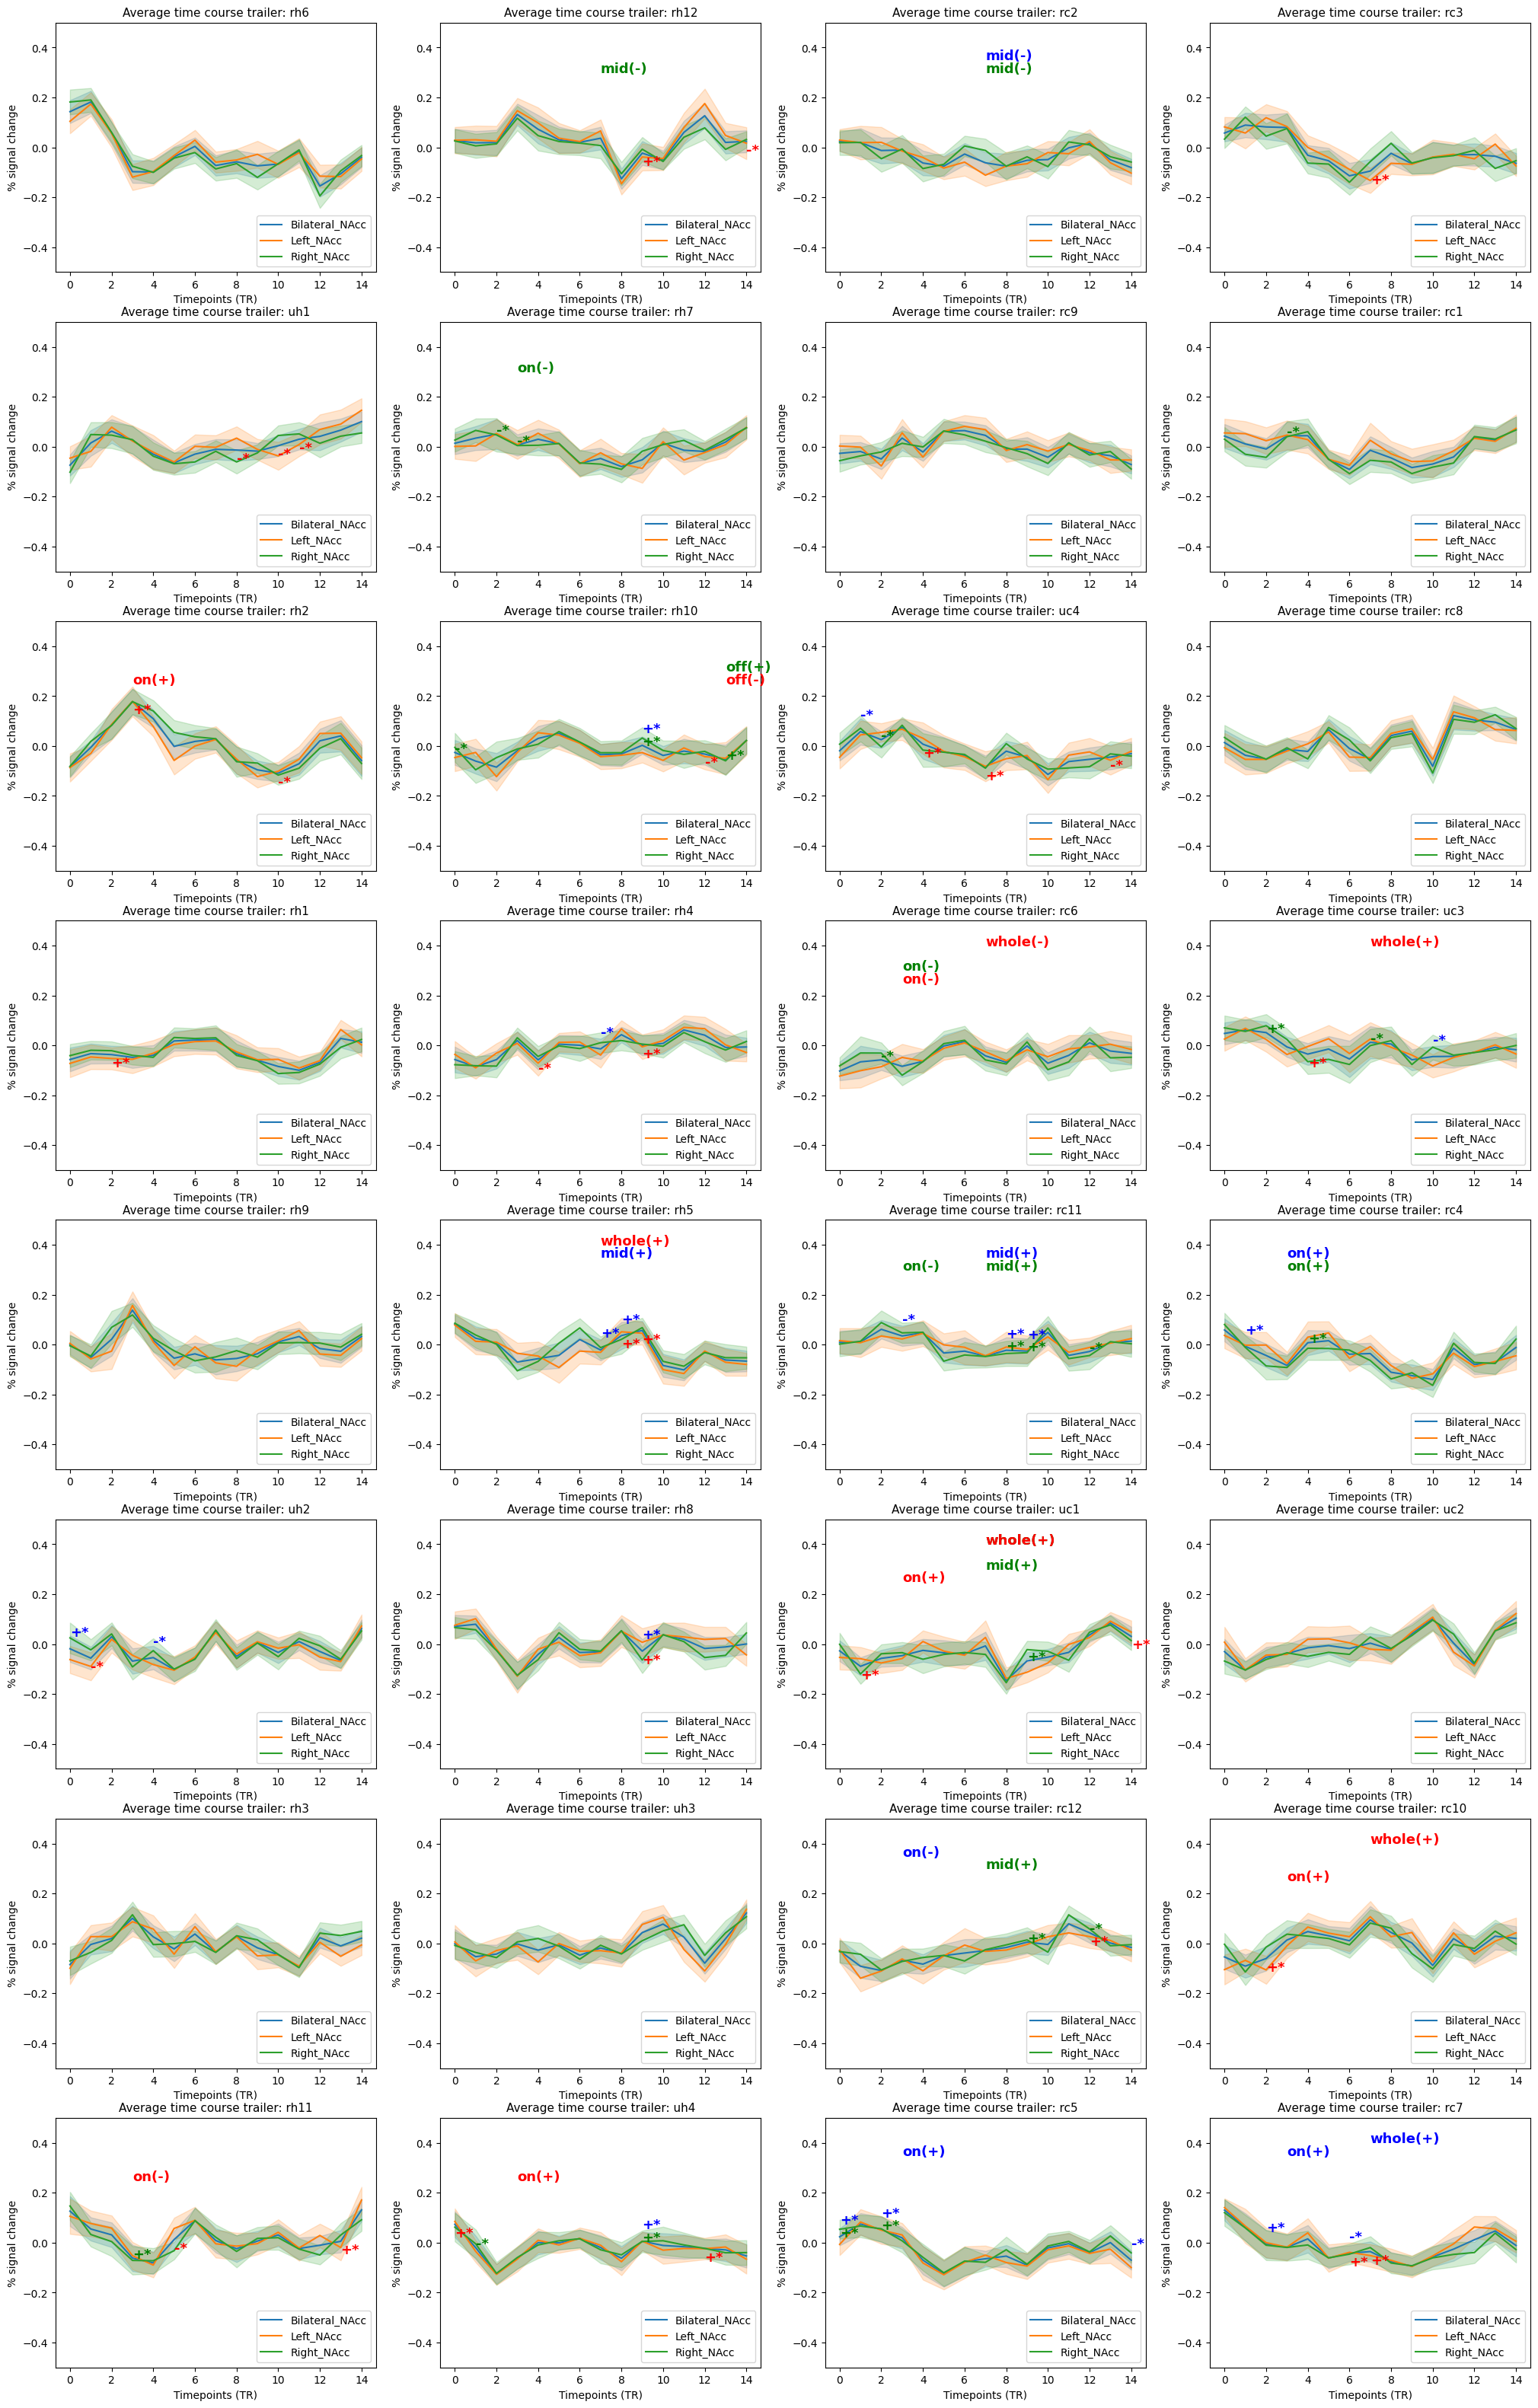

In [53]:
fig, axs = plt.subplots(8, 4, figsize=(25, 40), sharex=False)

runner = 0

for id in range(8):

    sns.lineplot(data=all_subjects_NAcc_timecourse_df[r1_keys_sorted[runner]], x="TR", y="Signal", hue="ROI", legend="brief", ax=axs[id, 0], errorbar="se")
    axs[id, 0].legend(loc='lower right', fontsize=10)
    axs[id, 0].set_title("Average time course trailer: " + str(r1_keys_sorted[runner]), size=11)
    axs[id, 0].set_ylabel('% signal change')
    axs[id, 0].set_xlabel('Timepoints (TR)')
    axs[id, 0].set_ylim(-.5, .5)
    plot_trailer_correlations(all_subjects_NAcc_timecourse_df, r1_keys_sorted[runner], "Bilateral_NAcc", NAcc_TR_correlations, "W_score", axs[id, 0])
    plot_trailer_correlations(all_subjects_NAcc_timecourse_df, r1_keys_sorted[runner], "Bilateral_NAcc", NAcc_TR_correlations, "Pos_arousal", axs[id, 0])
    plot_trailer_correlations(all_subjects_NAcc_timecourse_df, r1_keys_sorted[runner], "Bilateral_NAcc", NAcc_TR_correlations, "Neg_arousal", axs[id, 0])


    sns.lineplot(data=all_subjects_NAcc_timecourse_df[r2_keys_sorted[runner]], x="TR", y="Signal", hue="ROI", legend="brief", ax=axs[id, 1], errorbar="se")
    axs[id, 1].legend(loc='lower right', fontsize=10)
    axs[id, 1].set_title("Average time course trailer: " + str(r2_keys_sorted[runner]), size=11)
    axs[id, 1].set_ylabel('% signal change')
    axs[id, 1].set_xlabel('Timepoints (TR)')
    axs[id, 1].set_ylim(-.5, .5)
    plot_trailer_correlations(all_subjects_NAcc_timecourse_df, r2_keys_sorted[runner], "Bilateral_NAcc", NAcc_TR_correlations, "W_score", axs[id, 1])
    plot_trailer_correlations(all_subjects_NAcc_timecourse_df, r2_keys_sorted[runner], "Bilateral_NAcc", NAcc_TR_correlations, "Pos_arousal", axs[id, 1])
    plot_trailer_correlations(all_subjects_NAcc_timecourse_df, r2_keys_sorted[runner], "Bilateral_NAcc", NAcc_TR_correlations, "Neg_arousal", axs[id, 1])
    runner +=1

    sns.lineplot(data=all_subjects_NAcc_timecourse_df[r1_keys_sorted[runner]], x="TR", y="Signal", hue="ROI", legend="brief", ax=axs[id, 2], errorbar="se")
    axs[id, 2].legend(loc='lower right', fontsize=10)
    axs[id, 2].set_title("Average time course trailer: " + str(r1_keys_sorted[runner]), size=11)
    axs[id, 2].set_ylabel('% signal change')
    axs[id, 2].set_xlabel('Timepoints (TR)')
    axs[id, 2].set_ylim(-.5, .5)
    plot_trailer_correlations(all_subjects_NAcc_timecourse_df, r1_keys_sorted[runner], "Bilateral_NAcc", NAcc_TR_correlations, "W_score", axs[id, 2])
    plot_trailer_correlations(all_subjects_NAcc_timecourse_df, r1_keys_sorted[runner], "Bilateral_NAcc", NAcc_TR_correlations, "Pos_arousal", axs[id, 2])
    plot_trailer_correlations(all_subjects_NAcc_timecourse_df, r1_keys_sorted[runner], "Bilateral_NAcc", NAcc_TR_correlations, "Neg_arousal", axs[id, 2])


    sns.lineplot(data=all_subjects_NAcc_timecourse_df[r2_keys_sorted[runner]], x="TR", y="Signal", hue="ROI", legend="brief", ax=axs[id, 3], errorbar="se")
    axs[id, 3].legend(loc='lower right', fontsize=10)
    axs[id, 3].set_title("Average time course trailer: " + str(r2_keys_sorted[runner]), size=11)
    axs[id, 3].set_ylabel('% signal change')
    axs[id, 3].set_xlabel('Timepoints (TR)')
    axs[id, 3].set_ylim(-.5, .5)
    plot_trailer_correlations(all_subjects_NAcc_timecourse_df, r2_keys_sorted[runner], "Bilateral_NAcc", NAcc_TR_correlations, "W_score", axs[id, 3])
    plot_trailer_correlations(all_subjects_NAcc_timecourse_df, r2_keys_sorted[runner], "Bilateral_NAcc", NAcc_TR_correlations, "Pos_arousal", axs[id, 3])
    plot_trailer_correlations(all_subjects_NAcc_timecourse_df, r2_keys_sorted[runner], "Bilateral_NAcc", NAcc_TR_correlations, "Neg_arousal", axs[id, 3])
    runner +=1

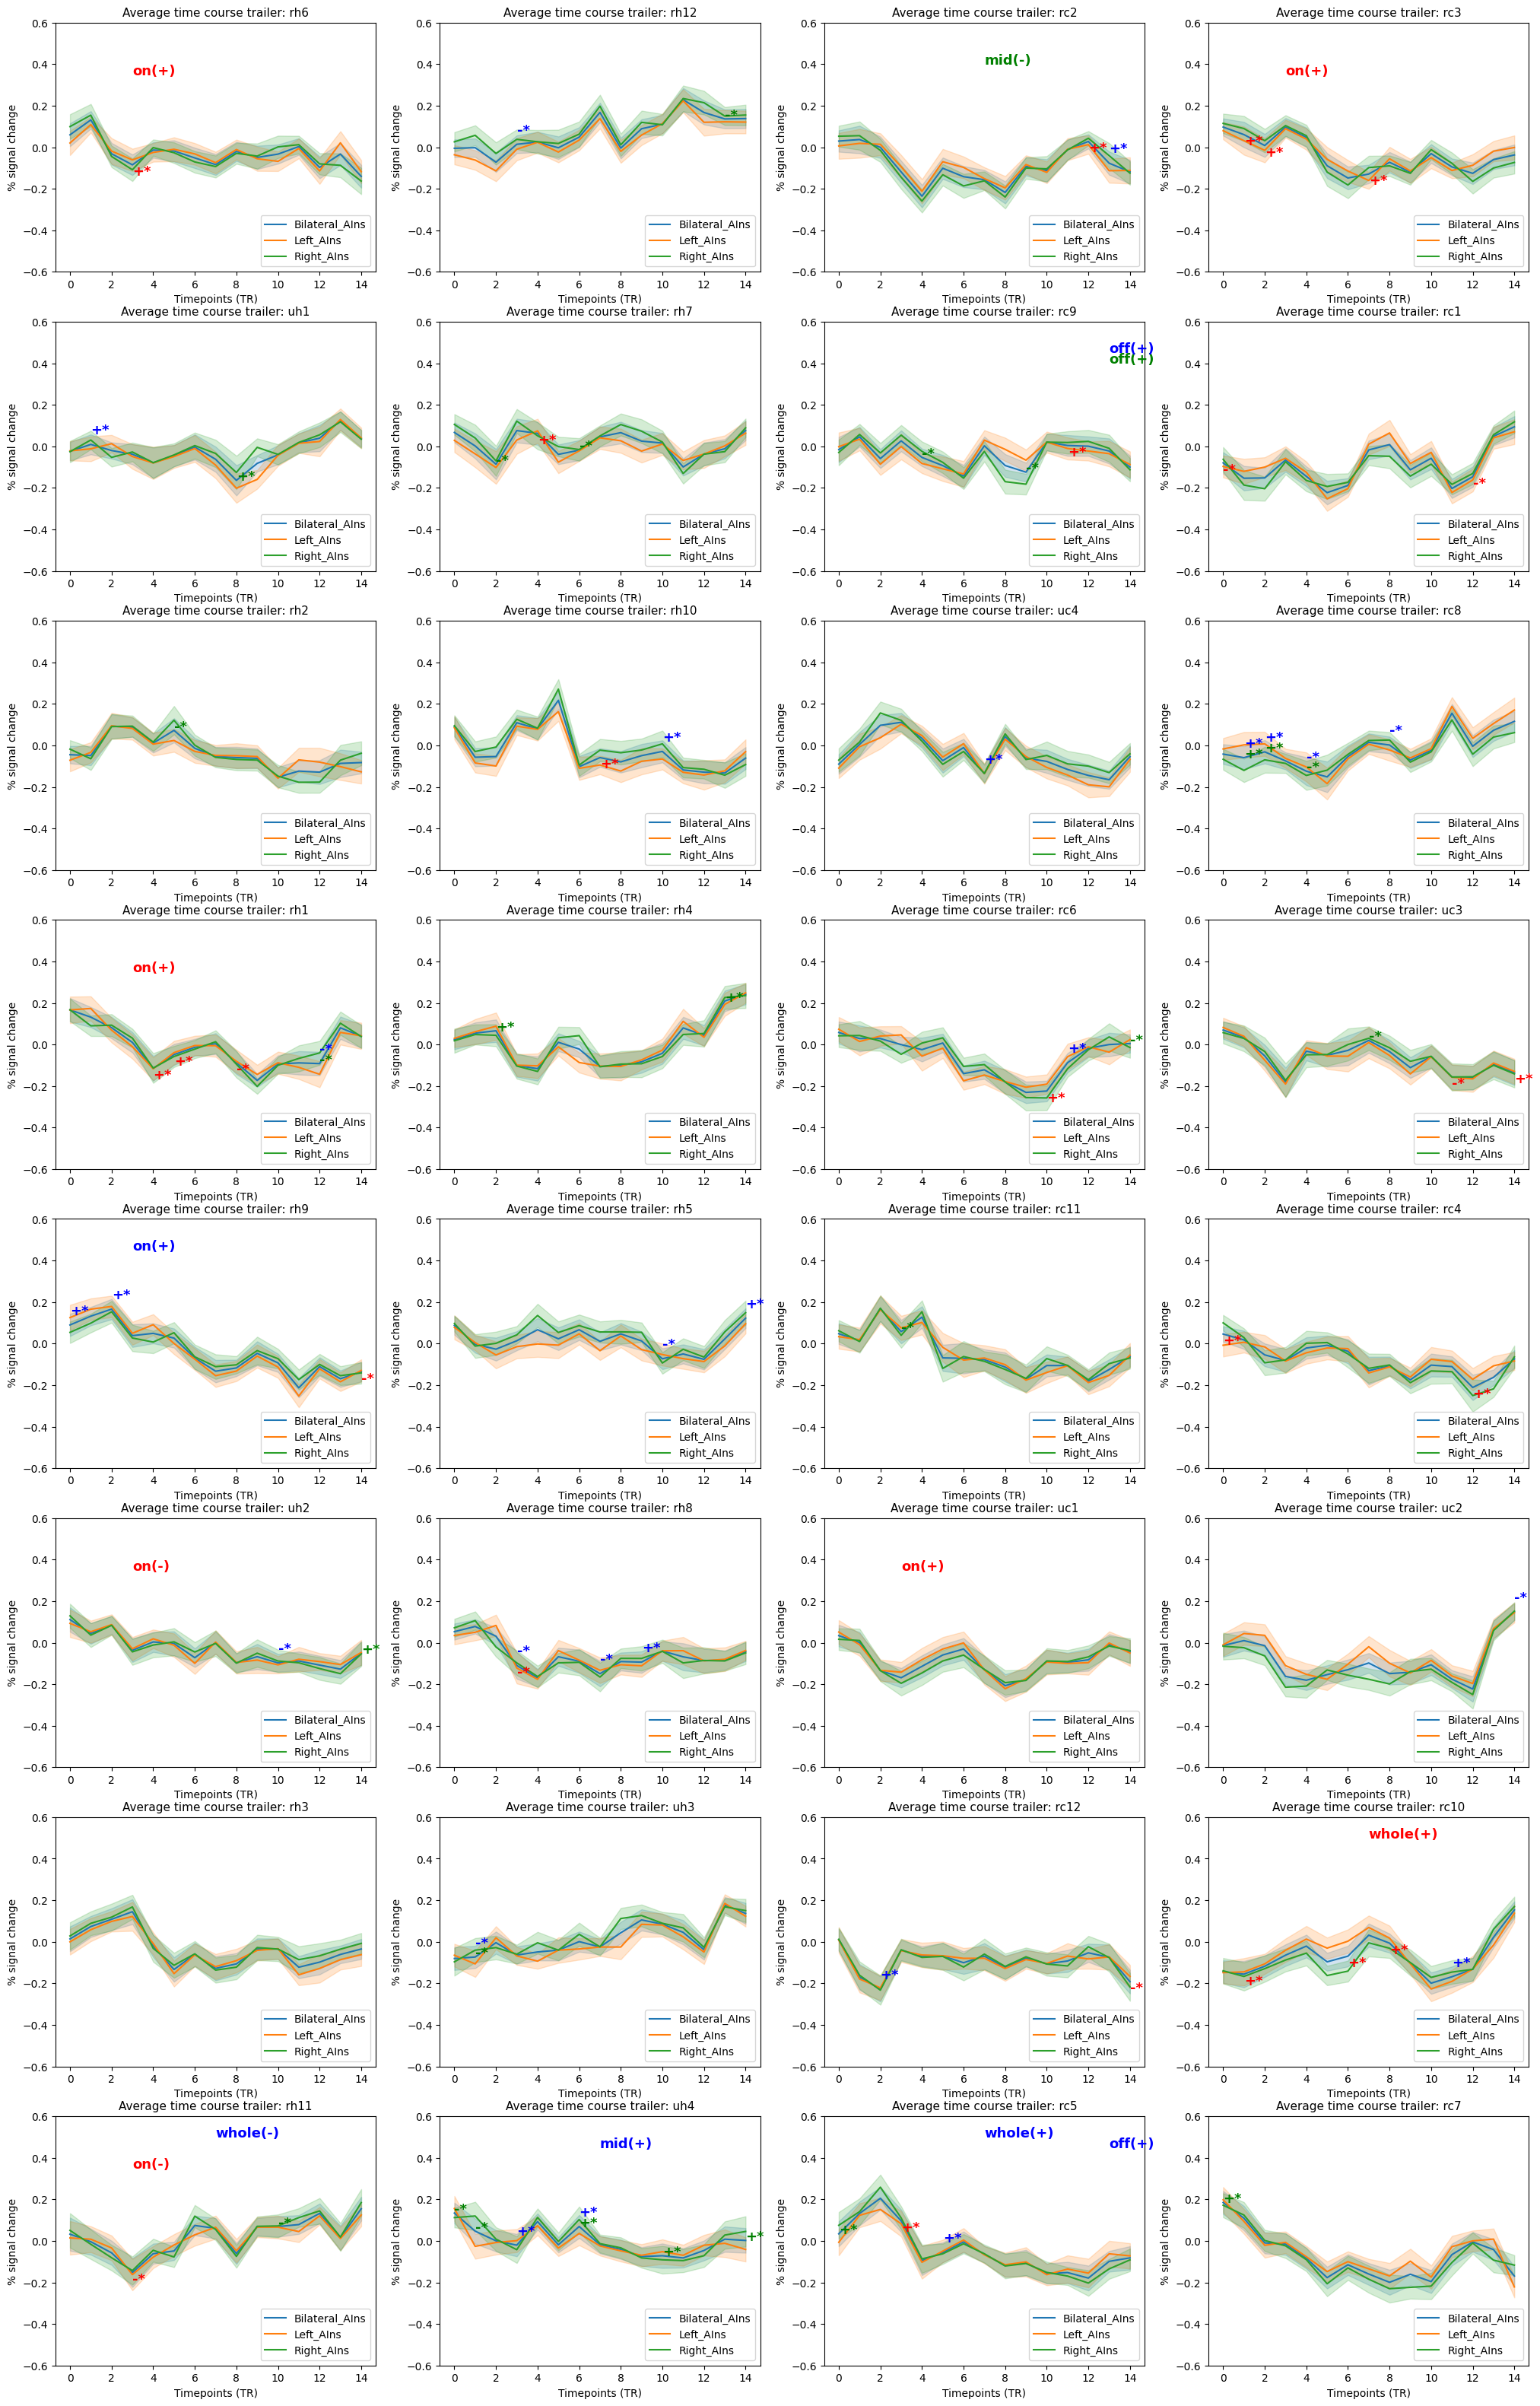

In [54]:
fig, axs = plt.subplots(8, 4, figsize=(25, 40), sharex=False)

runner = 0

for id in range(8):

    sns.lineplot(data=all_subjects_AIns_timecourse_df[r1_keys_sorted[runner]], x="TR", y="Signal", hue="ROI", legend="brief", ax=axs[id, 0], errorbar="se")
    axs[id, 0].legend(loc='lower right', fontsize=10)
    axs[id, 0].set_title("Average time course trailer: " + str(r1_keys_sorted[runner]), size=11)
    axs[id, 0].set_ylabel('% signal change')
    axs[id, 0].set_xlabel('Timepoints (TR)')
    axs[id, 0].set_ylim(-.6, .6)
    plot_trailer_correlations(all_subjects_AIns_timecourse_df, r1_keys_sorted[runner], "Bilateral_AIns", AIns_TR_correlations, "W_score", axs[id, 0])
    plot_trailer_correlations(all_subjects_AIns_timecourse_df, r1_keys_sorted[runner], "Bilateral_AIns", AIns_TR_correlations, "Pos_arousal", axs[id, 0])
    plot_trailer_correlations(all_subjects_AIns_timecourse_df, r1_keys_sorted[runner], "Bilateral_AIns", AIns_TR_correlations, "Neg_arousal", axs[id, 0])

    sns.lineplot(data=all_subjects_AIns_timecourse_df[r2_keys_sorted[runner]], x="TR", y="Signal", hue="ROI", legend="brief", ax=axs[id, 1], errorbar="se")
    axs[id, 1].legend(loc='lower right', fontsize=10)
    axs[id, 1].set_title("Average time course trailer: " + str(r2_keys_sorted[runner]), size=11)
    axs[id, 1].set_ylabel('% signal change')
    axs[id, 1].set_xlabel('Timepoints (TR)')
    axs[id, 1].set_ylim(-.6, .6)
    plot_trailer_correlations(all_subjects_AIns_timecourse_df, r2_keys_sorted[runner], "Bilateral_AIns", AIns_TR_correlations, "W_score", axs[id, 1])
    plot_trailer_correlations(all_subjects_AIns_timecourse_df, r2_keys_sorted[runner], "Bilateral_AIns", AIns_TR_correlations, "Pos_arousal", axs[id, 1])
    plot_trailer_correlations(all_subjects_AIns_timecourse_df, r2_keys_sorted[runner], "Bilateral_AIns", AIns_TR_correlations, "Neg_arousal", axs[id, 1])
    runner +=1

    sns.lineplot(data=all_subjects_AIns_timecourse_df[r1_keys_sorted[runner]], x="TR", y="Signal", hue="ROI", legend="brief", ax=axs[id, 2], errorbar="se")
    axs[id, 2].legend(loc='lower right', fontsize=10)
    axs[id, 2].set_title("Average time course trailer: " + str(r1_keys_sorted[runner]), size=11)
    axs[id, 2].set_ylabel('% signal change')
    axs[id, 2].set_xlabel('Timepoints (TR)')
    axs[id, 2].set_ylim(-.6, .6)
    plot_trailer_correlations(all_subjects_AIns_timecourse_df, r1_keys_sorted[runner], "Bilateral_AIns", AIns_TR_correlations, "W_score", axs[id, 2])
    plot_trailer_correlations(all_subjects_AIns_timecourse_df, r1_keys_sorted[runner], "Bilateral_AIns", AIns_TR_correlations, "Pos_arousal", axs[id, 2])
    plot_trailer_correlations(all_subjects_AIns_timecourse_df, r1_keys_sorted[runner], "Bilateral_AIns", AIns_TR_correlations, "Neg_arousal", axs[id, 2])

    sns.lineplot(data=all_subjects_AIns_timecourse_df[r2_keys_sorted[runner]], x="TR", y="Signal", hue="ROI", legend="brief", ax=axs[id, 3], errorbar="se")
    axs[id, 3].legend(loc='lower right', fontsize=10)
    axs[id, 3].set_title("Average time course trailer: " + str(r2_keys_sorted[runner]), size=11)
    axs[id, 3].set_ylabel('% signal change')
    axs[id, 3].set_xlabel('Timepoints (TR)')
    axs[id, 3].set_ylim(-.6, .6)
    plot_trailer_correlations(all_subjects_AIns_timecourse_df, r2_keys_sorted[runner], "Bilateral_AIns", AIns_TR_correlations, "W_score", axs[id, 3])
    plot_trailer_correlations(all_subjects_AIns_timecourse_df, r2_keys_sorted[runner], "Bilateral_AIns", AIns_TR_correlations, "Pos_arousal", axs[id, 3])
    plot_trailer_correlations(all_subjects_AIns_timecourse_df, r2_keys_sorted[runner], "Bilateral_AIns", AIns_TR_correlations, "Neg_arousal", axs[id, 3])
    runner +=1

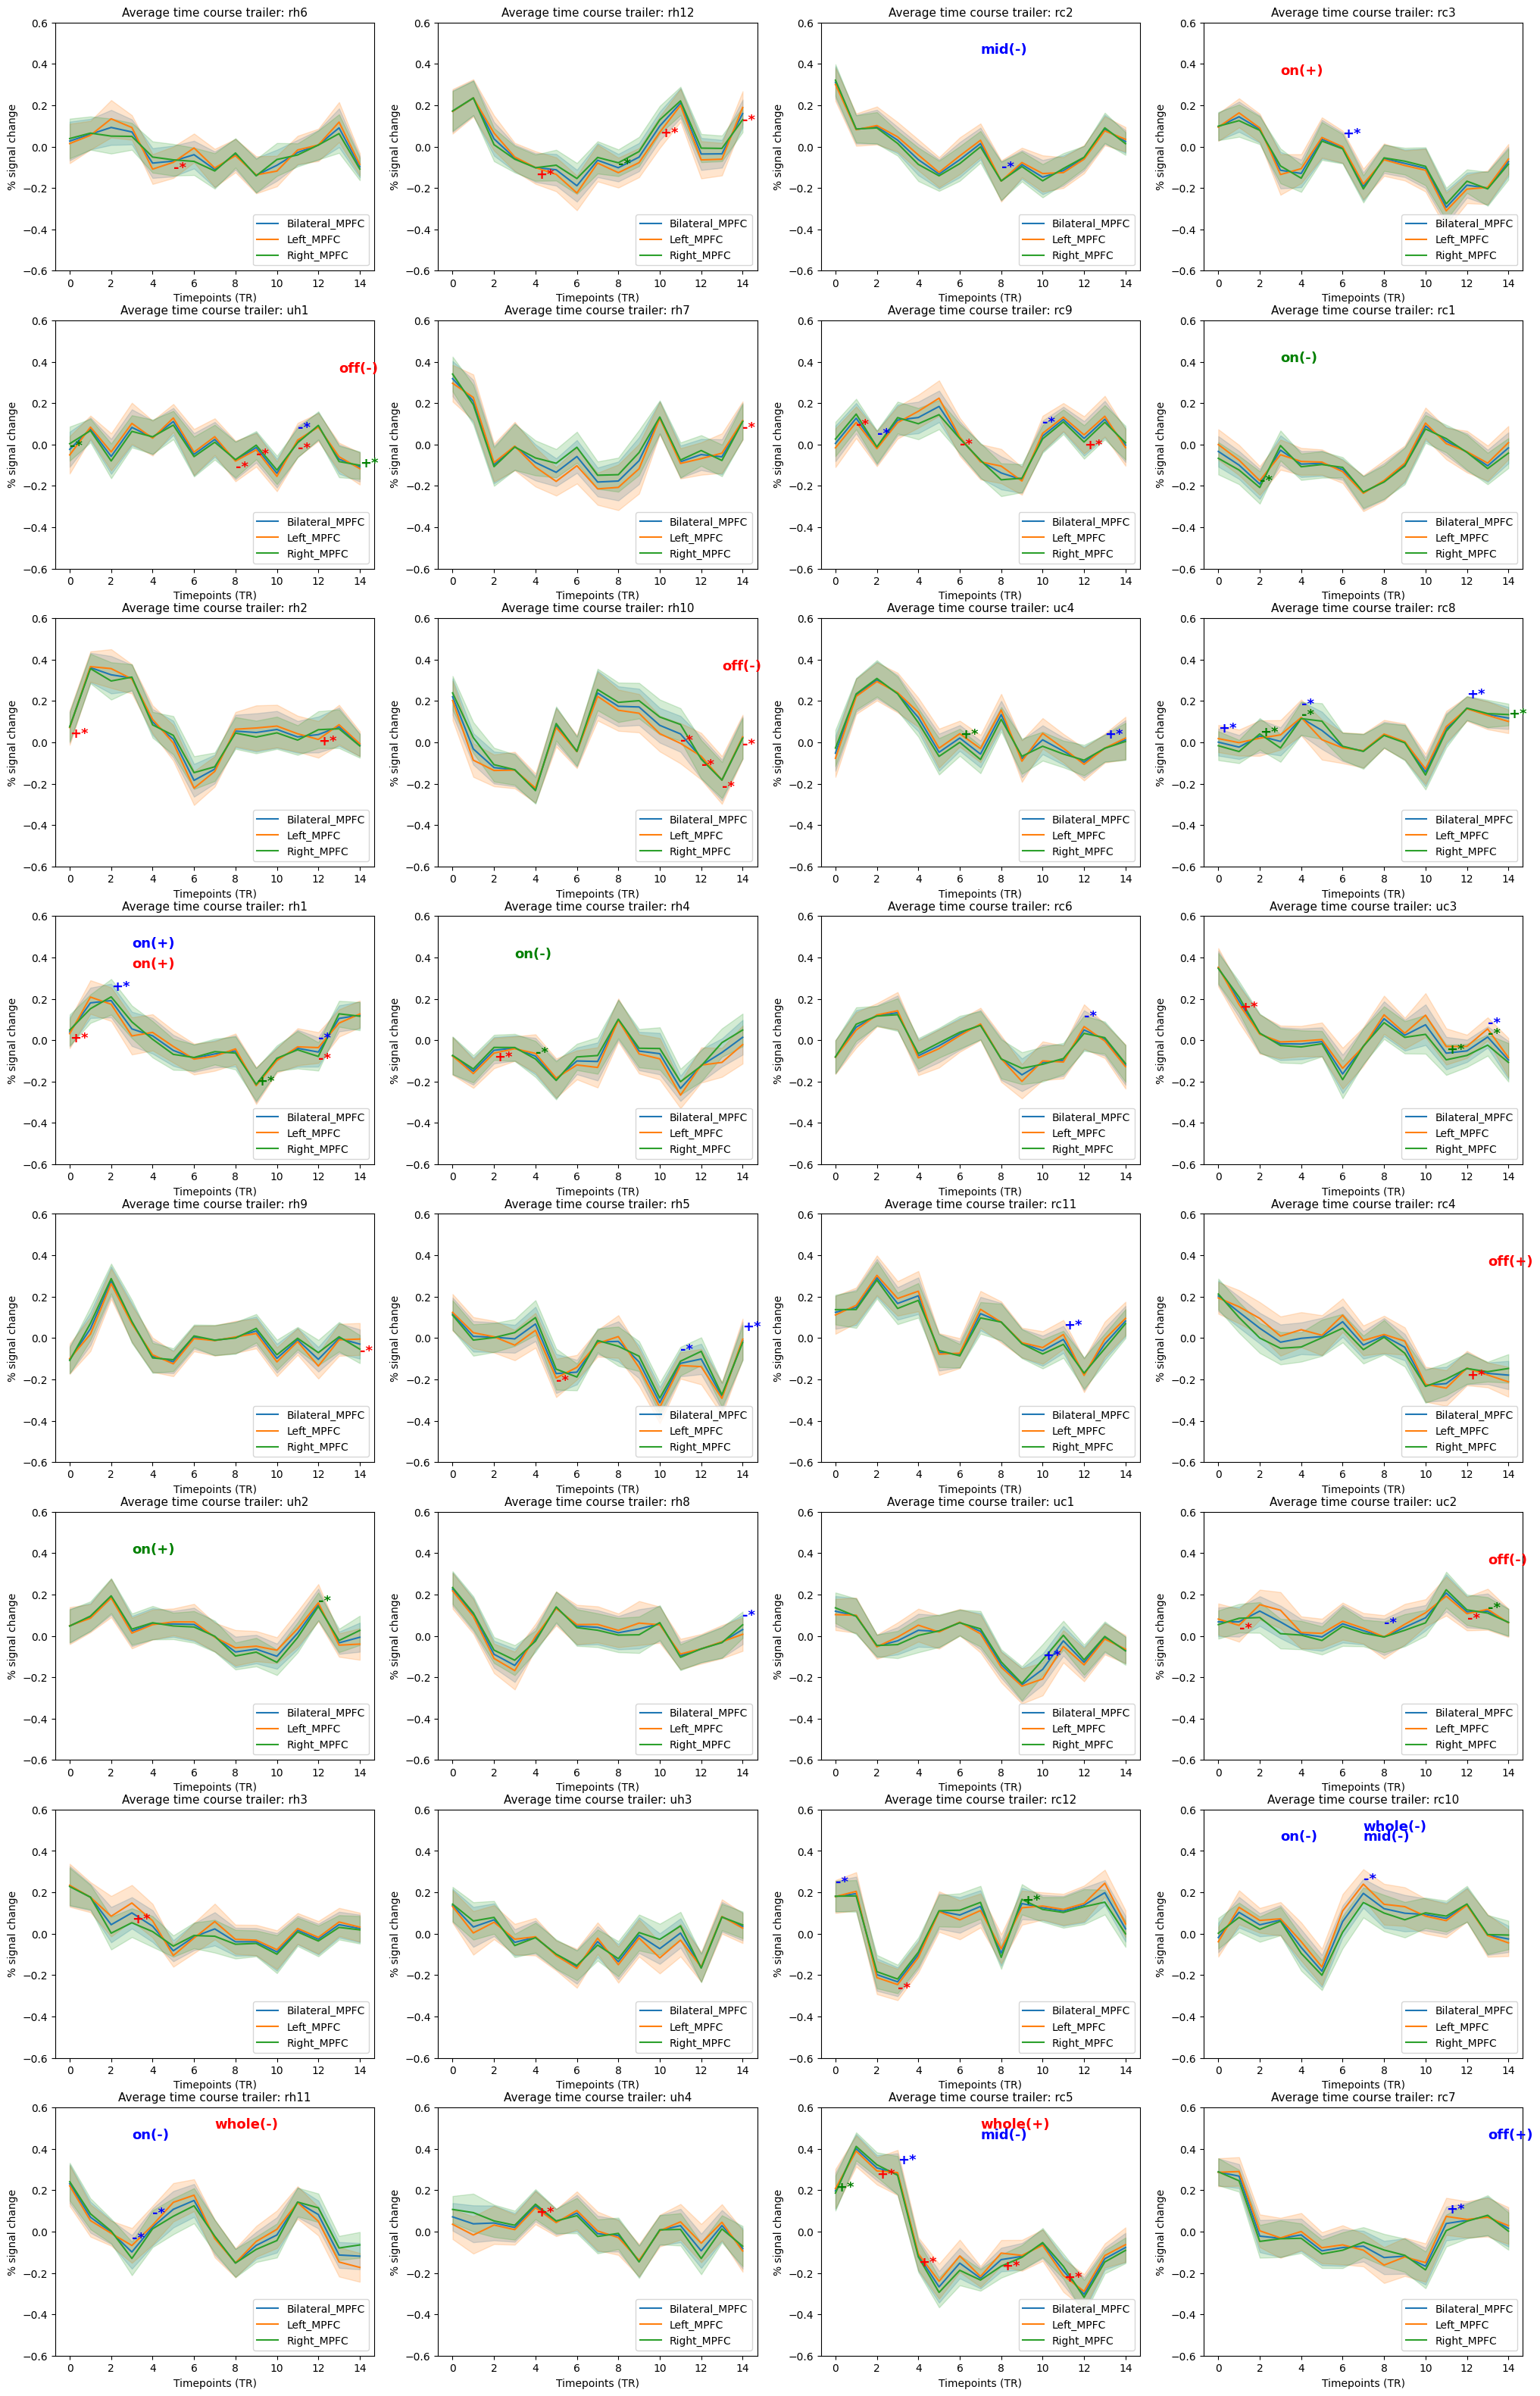

In [55]:
fig, axs = plt.subplots(8, 4, figsize=(25, 40), sharex=False)

runner = 0

for id in range(8):

    sns.lineplot(data=all_subjects_MPFC_timecourse_df[r1_keys_sorted[runner]], x="TR", y="Signal", hue="ROI", legend="brief", ax=axs[id, 0], errorbar="se")
    axs[id, 0].legend(loc='lower right', fontsize=10)
    axs[id, 0].set_title("Average time course trailer: " + str(r1_keys_sorted[runner]), size=11)
    axs[id, 0].set_ylabel('% signal change')
    axs[id, 0].set_xlabel('Timepoints (TR)')
    axs[id, 0].set_ylim(-.6, .6)
    plot_trailer_correlations(all_subjects_MPFC_timecourse_df, r1_keys_sorted[runner], "Bilateral_MPFC", MPFC_TR_correlations, "W_score", axs[id, 0])
    plot_trailer_correlations(all_subjects_MPFC_timecourse_df, r1_keys_sorted[runner], "Bilateral_MPFC", MPFC_TR_correlations, "Pos_arousal", axs[id, 0])
    plot_trailer_correlations(all_subjects_MPFC_timecourse_df, r1_keys_sorted[runner], "Bilateral_MPFC", MPFC_TR_correlations, "Neg_arousal", axs[id, 0])

    sns.lineplot(data=all_subjects_MPFC_timecourse_df[r2_keys_sorted[runner]], x="TR", y="Signal", hue="ROI", legend="brief", ax=axs[id, 1], errorbar="se")
    axs[id, 1].legend(loc='lower right', fontsize=10)
    axs[id, 1].set_title("Average time course trailer: " + str(r2_keys_sorted[runner]), size=11)
    axs[id, 1].set_ylabel('% signal change')
    axs[id, 1].set_xlabel('Timepoints (TR)')
    axs[id, 1].set_ylim(-.6, .6)
    plot_trailer_correlations(all_subjects_MPFC_timecourse_df, r2_keys_sorted[runner], "Bilateral_MPFC", MPFC_TR_correlations, "W_score", axs[id, 1])
    plot_trailer_correlations(all_subjects_MPFC_timecourse_df, r2_keys_sorted[runner], "Bilateral_MPFC", MPFC_TR_correlations, "Pos_arousal", axs[id, 1])
    plot_trailer_correlations(all_subjects_MPFC_timecourse_df, r2_keys_sorted[runner], "Bilateral_MPFC", MPFC_TR_correlations, "Neg_arousal", axs[id, 1])
    runner +=1

    sns.lineplot(data=all_subjects_MPFC_timecourse_df[r1_keys_sorted[runner]], x="TR", y="Signal", hue="ROI", legend="brief", ax=axs[id, 2], errorbar="se")
    axs[id, 2].legend(loc='lower right', fontsize=10)
    axs[id, 2].set_title("Average time course trailer: " + str(r1_keys_sorted[runner]), size=11)
    axs[id, 2].set_ylabel('% signal change')
    axs[id, 2].set_xlabel('Timepoints (TR)')
    axs[id, 2].set_ylim(-.6, .6)
    plot_trailer_correlations(all_subjects_MPFC_timecourse_df, r1_keys_sorted[runner], "Bilateral_MPFC", MPFC_TR_correlations, "W_score", axs[id, 2])
    plot_trailer_correlations(all_subjects_MPFC_timecourse_df, r1_keys_sorted[runner], "Bilateral_MPFC", MPFC_TR_correlations, "Pos_arousal", axs[id, 2])
    plot_trailer_correlations(all_subjects_MPFC_timecourse_df, r1_keys_sorted[runner], "Bilateral_MPFC", MPFC_TR_correlations, "Neg_arousal", axs[id, 2])

    sns.lineplot(data=all_subjects_MPFC_timecourse_df[r2_keys_sorted[runner]], x="TR", y="Signal", hue="ROI", legend="brief", ax=axs[id, 3], errorbar="se") 
    axs[id, 3].legend(loc='lower right', fontsize=10)
    axs[id, 3].set_title("Average time course trailer: " + str(r2_keys_sorted[runner]), size=11)
    axs[id, 3].set_ylabel('% signal change')
    axs[id, 3].set_xlabel('Timepoints (TR)')
    axs[id, 3].set_ylim(-.6, .6)
    plot_trailer_correlations(all_subjects_MPFC_timecourse_df, r2_keys_sorted[runner], "Bilateral_MPFC", MPFC_TR_correlations, "W_score", axs[id, 3])
    plot_trailer_correlations(all_subjects_MPFC_timecourse_df, r2_keys_sorted[runner], "Bilateral_MPFC", MPFC_TR_correlations, "Pos_arousal", axs[id, 3])
    plot_trailer_correlations(all_subjects_MPFC_timecourse_df, r2_keys_sorted[runner], "Bilateral_MPFC", MPFC_TR_correlations, "Neg_arousal", axs[id, 3])
    runner +=1

In [56]:
# Save each participants timecourse data and processed events to a csv files.

save_path = "/Users/luisalvarez/Documents/GitHub/RM_Thesis_Neuroforecasting/ProcessedData/"

for id_participant in range(len(particpants_list)):
    
    current_sub = "sub-" + particpants_list[id_participant]
    print("Processing and saving files for : "  + current_sub)

    participants_events[current_sub].to_csv(save_path + current_sub + "/" + current_sub + "_processed_events.csv", index=False)

    # Create empty dataframe for current participant.
    current_participant_df = pd.DataFrame(columns=["Participant"], data=np.repeat(current_sub, 15))

    # Current participant trailer keys.
    current_sub_trailer_keys = participants_events[current_sub]["Trailer"].unique()

    for id_trailer in current_sub_trailer_keys:

        for id_tr in range(15):

            col_label_NAcc = id_trailer + "_bNAcc"
            col_lable_AIns = id_trailer + "_bAIns"
            col_lable_MPFC = id_trailer + "_bMPFC"
            
            current_participant_df[col_label_NAcc] = participant_dictionaries[current_sub][id_trailer]["Bilateral_NAcc"]
            current_participant_df[col_lable_AIns] = participant_dictionaries[current_sub][id_trailer]["Bilateral_AIns"]
            current_participant_df[col_lable_MPFC] = participant_dictionaries[current_sub][id_trailer]["Bilateral_MPFC"]
    
    current_participant_df.to_csv(save_path + current_sub + "/" + current_sub + "_AIM_ROI_NeuralActivation.csv", index=False)


Processing and saving files for : sub-01
Processing and saving files for : sub-02
Processing and saving files for : sub-03
Processing and saving files for : sub-04
Processing and saving files for : sub-08
Processing and saving files for : sub-09
Processing and saving files for : sub-10
Processing and saving files for : sub-11
Processing and saving files for : sub-12
Processing and saving files for : sub-13
Processing and saving files for : sub-15
Processing and saving files for : sub-17
Processing and saving files for : sub-18
Processing and saving files for : sub-19
Processing and saving files for : sub-21
Processing and saving files for : sub-22
Processing and saving files for : sub-23
Processing and saving files for : sub-25
Processing and saving files for : sub-26
Processing and saving files for : sub-27
Processing and saving files for : sub-28
Processing and saving files for : sub-29
Processing and saving files for : sub-30
Processing and saving files for : sub-31
Processing and s

# Process all participants data

In [57]:
# Open a datasets directory. 
fd = os.open("/Users/luisalvarez/Documents/GitHub/RM_Thesis_Neuroforecasting/ProcessedData", os.O_RDONLY)


# Use os.fchdir() method to change the current dir/folder.
os.fchdir(fd)

# Safe check- Print current working directory
print("Current working dir : %s" % os.getcwd())

root_path = os.getcwd()

Current working dir : /Users/luisalvarez/Documents/GitHub/RM_Thesis_Neuroforecasting/ProcessedData


In [58]:
all_cols = ['Participant', 'Trailer', 'Type', 'Onset', 'Offset', 'Duration', 'W_score', 'A_score',
       'F_score', 'NAcc_onset', 'AIns_onset', 'MPFC_onset', 'NAcc_middle',
       'AIns_middle', 'MPFC_middle', 'NAcc_offset', 'AIns_offset',
       'MPFC_offset']

all_subs_events_df = pd.DataFrame(columns = all_cols)

#particpants_list = ["01", "02", "03", "04", "08", "09", "10", "11", "12", "13", "17", "18"]
# particpants_list = ["01", "02", "03", "04", "07", "08", "09", "10", "11", "12", "13", "15",
#                     "16", "17", "18", "19", "21", "22", "23", "25", "26", "27", "28", "29",
#                     "30", "31", "32", "33", "34", "35", "36", "37"]


# Loop through each participant's data.
for sub_num in particpants_list:

    current_sub = str("sub-" + sub_num)
    current_sub_events_path = root_path + "/" + current_sub + "/" + current_sub + "_processed_events.csv"
    current_sub_AIM_path = root_path + "/" + current_sub + "/" + current_sub + "_AIM_ROI_NeuralActivation.csv"

    current_sub_events_df = pd.read_csv(current_sub_events_path)
    current_sub_AIM_df = pd.read_csv(current_sub_AIM_path)
    current_sub_zscored_dict = participant_dictionaries_zscored[current_sub]

    trailer_keys = current_sub_events_df["Trailer"].unique().tolist()

    # Create empty lists to store the mean onset, middle, offset, and whole activation for each ROI.
    NAcc_onset = []
    AIns_onset = []
    MPFC_onset = []
    NAcc_onset_z = []
    AIns_onset_z = []
    MPFC_onset_z = []

    NAcc_middle = []
    AIns_middle = []
    MPFC_middle = []
    NAcc_middle_z = []
    AIns_middle_z = []
    MPFC_middle_z = []

    NAcc_offset = []
    AIns_offset = []
    MPFC_offset = []
    NAcc_offset_z = []
    AIns_offset_z = []
    MPFC_offset_z = []

    NAcc_whole = []
    AIns_whole = []
    MPFC_whole = []
    NAcc_whole_z = []
    AIns_whole_z = []
    MPFC_whole_z = []

    # Create list to store individual peaks. 
    NAcc_ind_peaks_pos = []
    AIns_ind_peaks_pos = []
    MPFC_ind_peaks_pos = []

    NAcc_ind_peaks_neg = []
    AIns_ind_peaks_neg = []
    MPFC_ind_peaks_neg = []

    # Creat empty lists to store positive peaks for each ROI.
    NAcc_pos_peak = []
    AIns_pos_peak = []
    MPFC_pos_peak = []

    # Create empty lists to store negative peaks for each ROI.
    NAcc_neg_peak = []
    AIns_neg_peak = []
    MPFC_neg_peak = []

    # Create empty lists to store the slope peak for each ROI. 
    NAcc_slope_peak = []
    AIns_slope_peak = []
    MPFC_slope_peak = []

    NAcc_slope_peak_avg = []
    AIns_slope_peak_avg = []
    MPFC_slope_peak_avg = []

    # Create empty lists to store the delta peak for each ROI.
    NAcc_delta_peak = []
    AIns_delta_peak = []
    MPFC_delta_peak = []

    NAcc_delta_peak_avg = []
    AIns_delta_peak_avg = []
    MPFC_delta_peak_avg = []

    # Create empty lists to store NAcc individual TRs.
    NAcc_TR1 = []
    NAcc_TR2 = []
    NAcc_TR3 = []
    NAcc_TR4 = []
    NAcc_TR5 = []
    NAcc_TR6 = []
    NAcc_TR7 = []
    NAcc_TR8 = []
    NAcc_TR9 = []
    NAcc_TR10 = []
    NAcc_TR11 = []
    NAcc_TR12 = []
    NAcc_TR13 = []
    NAcc_TR14 = []
    NAcc_TR15 = []

    # Create empty lists to store AIns individual TRs.
    AIns_TR1 = []
    AIns_TR2 = []
    AIns_TR3 = []
    AIns_TR4 = []
    AIns_TR5 = []
    AIns_TR6 = []
    AIns_TR7 = []
    AIns_TR8 = []
    AIns_TR9 = []
    AIns_TR10 = []
    AIns_TR11 = []
    AIns_TR12 = []
    AIns_TR13 = []
    AIns_TR14 = []
    AIns_TR15 = []

    # Create empty lists to store MPFC individual TRs.
    MPFC_TR1 = []
    MPFC_TR2 = []
    MPFC_TR3 = []
    MPFC_TR4 = []
    MPFC_TR5 = []
    MPFC_TR6 = []
    MPFC_TR7 = []
    MPFC_TR8 = []
    MPFC_TR9 = []
    MPFC_TR10 = []
    MPFC_TR11 = []
    MPFC_TR12 = []
    MPFC_TR13 = []
    MPFC_TR14 = []
    MPFC_TR15 = []

    # Loop through each trailer. 
    for id_trailer in range(len(trailer_keys)):

        # Create keys to access AIM_df columns.
        NAcc_key = trailer_keys[id_trailer] + "_bNAcc" 
        AIns_key = trailer_keys[id_trailer] + "_bAIns"
        MPFC_key = trailer_keys[id_trailer] + "_bMPFC"

        # Calculate ROI mean onset (1-5 TRs) activation for each trailer. 
        # And append to the corresponding list.
        NAcc_onset.append(current_sub_AIM_df[NAcc_key][0:5].mean())
        AIns_onset.append(current_sub_AIM_df[AIns_key][0:5].mean())
        MPFC_onset.append(current_sub_AIM_df[MPFC_key][0:5].mean())
        NAcc_onset_z.append(current_sub_zscored_dict[trailer_keys[id_trailer]]["Bilateral_NAcc_zscored"][0:5].mean())
        AIns_onset_z.append(current_sub_zscored_dict[trailer_keys[id_trailer]]["Bilateral_AIns_zscored"][0:5].mean())
        MPFC_onset_z.append(current_sub_zscored_dict[trailer_keys[id_trailer]]["Bilateral_MPFC_zscored"][0:5].mean())

        # Calculate ROI mean middle (6-10 TRs) activation for each trailer.
        NAcc_middle.append(current_sub_AIM_df[NAcc_key][5:10].mean())
        AIns_middle.append(current_sub_AIM_df[AIns_key][5:10].mean())
        MPFC_middle.append(current_sub_AIM_df[MPFC_key][5:10].mean())
        NAcc_middle_z.append(current_sub_zscored_dict[trailer_keys[id_trailer]]["Bilateral_NAcc_zscored"][5:10].mean())
        AIns_middle_z.append(current_sub_zscored_dict[trailer_keys[id_trailer]]["Bilateral_AIns_zscored"][5:10].mean())
        MPFC_middle_z.append(current_sub_zscored_dict[trailer_keys[id_trailer]]["Bilateral_MPFC_zscored"][5:10].mean())

        # Calculate ROI mean offset (11-15 TRs) activation for each trailer.
        NAcc_offset.append(current_sub_AIM_df[NAcc_key][10:].mean())
        AIns_offset.append(current_sub_AIM_df[AIns_key][10:].mean())
        MPFC_offset.append(current_sub_AIM_df[MPFC_key][10:].mean())
        NAcc_offset_z.append(current_sub_zscored_dict[trailer_keys[id_trailer]]["Bilateral_NAcc_zscored"][10:].mean())
        AIns_offset_z.append(current_sub_zscored_dict[trailer_keys[id_trailer]]["Bilateral_AIns_zscored"][10:].mean())
        MPFC_offset_z.append(current_sub_zscored_dict[trailer_keys[id_trailer]]["Bilateral_MPFC_zscored"][10:].mean())

        # Calculate ROI mean whole activation for each trailer.
        NAcc_whole.append(current_sub_AIM_df[NAcc_key].mean())
        AIns_whole.append(current_sub_AIM_df[AIns_key].mean())
        MPFC_whole.append(current_sub_AIM_df[MPFC_key].mean())
        NAcc_whole_z.append(current_sub_zscored_dict[trailer_keys[id_trailer]]["Bilateral_NAcc_zscored"].mean())
        AIns_whole_z.append(current_sub_zscored_dict[trailer_keys[id_trailer]]["Bilateral_AIns_zscored"].mean())    
        MPFC_whole_z.append(current_sub_zscored_dict[trailer_keys[id_trailer]]["Bilateral_MPFC_zscored"].mean())

        # Calculate individual peaks for each ROI.
        NAcc_ind_peaks_pos.append(get_individual_peak(current_sub_AIM_df[NAcc_key][:], "max")) 
        AIns_ind_peaks_pos.append(get_individual_peak(current_sub_AIM_df[AIns_key][:], "max"))
        MPFC_ind_peaks_pos.append(get_individual_peak(current_sub_AIM_df[MPFC_key][:], "max"))

        NAcc_ind_peaks_neg.append(get_individual_peak(current_sub_AIM_df[NAcc_key][:], "min"))
        AIns_ind_peaks_neg.append(get_individual_peak(current_sub_AIM_df[AIns_key][:], "min"))
        MPFC_ind_peaks_neg.append(get_individual_peak(current_sub_AIM_df[MPFC_key][:], "min"))

        # Calculate peaks for each ROI.
        NAcc_pos_peak.append(current_sub_AIM_df[NAcc_key].max())
        AIns_pos_peak.append(current_sub_AIM_df[AIns_key].max())
        MPFC_pos_peak.append(current_sub_AIM_df[MPFC_key].max())

        NAcc_neg_peak.append(current_sub_AIM_df[NAcc_key].min())
        AIns_neg_peak.append(current_sub_AIM_df[AIns_key].min())
        MPFC_neg_peak.append(current_sub_AIM_df[MPFC_key].min())

        # Calculate slope peak.
        current_sub_trailer_NAcc_z = current_sub_zscored_dict[trailer_keys[id_trailer]]["Bilateral_NAcc_zscored"]
        current_sub_trailer_AIns_z = current_sub_zscored_dict[trailer_keys[id_trailer]]["Bilateral_AIns_zscored"]
        current_sub_trailer_MPFC_z = current_sub_zscored_dict[trailer_keys[id_trailer]]["Bilateral_MPFC_zscored"]

        NAcc_current_peak, NAcc_current_avg_peak = get_peak_slope(current_sub_AIM_df[NAcc_key], current_sub_trailer_NAcc_z, 1, "max")
        AIns_current_peak, AIns_current_avg_peak = get_peak_slope(current_sub_AIM_df[AIns_key], current_sub_trailer_AIns_z, 1, "max")
        MPFC_current_peak, MPFC_current_avg_peak = get_peak_slope(current_sub_AIM_df[MPFC_key], current_sub_trailer_MPFC_z, 1, "max")

        NAcc_slope_peak.append(NAcc_current_peak)
        NAcc_slope_peak_avg.append(NAcc_current_avg_peak)
        AIns_slope_peak.append(AIns_current_peak)
        AIns_slope_peak_avg.append(AIns_current_avg_peak)
        MPFC_slope_peak.append(MPFC_current_peak)
        MPFC_slope_peak_avg.append(MPFC_current_avg_peak)

        # Calculate delta peak.
        NAcc_current_delta_peak, NAcc_current_avg_delta_peak = get_peak_delta(current_sub_AIM_df[NAcc_key], current_sub_trailer_NAcc_z, 1, "max")
        AIns_current_delta_peak, AIns_current_avg_delta_peak = get_peak_delta(current_sub_AIM_df[AIns_key], current_sub_trailer_AIns_z, 1, "max")
        MPFC_current_delta_peak, MPFC_current_avg_delta_peak = get_peak_delta(current_sub_AIM_df[MPFC_key], current_sub_trailer_MPFC_z, 1, "max")

        NAcc_delta_peak.append(NAcc_current_delta_peak)
        NAcc_delta_peak_avg.append(NAcc_current_avg_delta_peak)
        AIns_delta_peak.append(AIns_current_delta_peak)
        AIns_delta_peak_avg.append(AIns_current_avg_delta_peak)
        MPFC_delta_peak.append(MPFC_current_delta_peak)
        MPFC_delta_peak_avg.append(MPFC_current_avg_delta_peak)

        # Append individual TRs for each ROI.
        NAcc_TR1.append(current_sub_AIM_df[NAcc_key][0])
        NAcc_TR2.append(current_sub_AIM_df[NAcc_key][1])
        NAcc_TR3.append(current_sub_AIM_df[NAcc_key][2])
        NAcc_TR4.append(current_sub_AIM_df[NAcc_key][3])
        NAcc_TR5.append(current_sub_AIM_df[NAcc_key][4])
        NAcc_TR6.append(current_sub_AIM_df[NAcc_key][5])
        NAcc_TR7.append(current_sub_AIM_df[NAcc_key][6])
        NAcc_TR8.append(current_sub_AIM_df[NAcc_key][7])
        NAcc_TR9.append(current_sub_AIM_df[NAcc_key][8])
        NAcc_TR10.append(current_sub_AIM_df[NAcc_key][9])
        NAcc_TR11.append(current_sub_AIM_df[NAcc_key][10])
        NAcc_TR12.append(current_sub_AIM_df[NAcc_key][11])
        NAcc_TR13.append(current_sub_AIM_df[NAcc_key][12])
        NAcc_TR14.append(current_sub_AIM_df[NAcc_key][13])
        NAcc_TR15.append(current_sub_AIM_df[NAcc_key][14])

        AIns_TR1.append(current_sub_AIM_df[AIns_key][0])
        AIns_TR2.append(current_sub_AIM_df[AIns_key][1])
        AIns_TR3.append(current_sub_AIM_df[AIns_key][2])
        AIns_TR4.append(current_sub_AIM_df[AIns_key][3])
        AIns_TR5.append(current_sub_AIM_df[AIns_key][4])
        AIns_TR6.append(current_sub_AIM_df[AIns_key][5])
        AIns_TR7.append(current_sub_AIM_df[AIns_key][6])
        AIns_TR8.append(current_sub_AIM_df[AIns_key][7])
        AIns_TR9.append(current_sub_AIM_df[AIns_key][8])
        AIns_TR10.append(current_sub_AIM_df[AIns_key][9])
        AIns_TR11.append(current_sub_AIM_df[AIns_key][10])
        AIns_TR12.append(current_sub_AIM_df[AIns_key][11])
        AIns_TR13.append(current_sub_AIM_df[AIns_key][12])
        AIns_TR14.append(current_sub_AIM_df[AIns_key][13])
        AIns_TR15.append(current_sub_AIM_df[AIns_key][14])

        MPFC_TR1.append(current_sub_AIM_df[MPFC_key][0])
        MPFC_TR2.append(current_sub_AIM_df[MPFC_key][1])
        MPFC_TR3.append(current_sub_AIM_df[MPFC_key][2])
        MPFC_TR4.append(current_sub_AIM_df[MPFC_key][3])
        MPFC_TR5.append(current_sub_AIM_df[MPFC_key][4])
        MPFC_TR6.append(current_sub_AIM_df[MPFC_key][5])
        MPFC_TR7.append(current_sub_AIM_df[MPFC_key][6])
        MPFC_TR8.append(current_sub_AIM_df[MPFC_key][7])
        MPFC_TR9.append(current_sub_AIM_df[MPFC_key][8])
        MPFC_TR10.append(current_sub_AIM_df[MPFC_key][9])
        MPFC_TR11.append(current_sub_AIM_df[MPFC_key][10])
        MPFC_TR12.append(current_sub_AIM_df[MPFC_key][11])
        MPFC_TR13.append(current_sub_AIM_df[MPFC_key][12])
        MPFC_TR14.append(current_sub_AIM_df[MPFC_key][13])
        MPFC_TR15.append(current_sub_AIM_df[MPFC_key][14])

    # Append the mean activation and ISC scores to the current_sub_events_df.
    current_sub_events_df["NAcc_onset"] = NAcc_onset
    current_sub_events_df["AIns_onset"] = AIns_onset
    current_sub_events_df["MPFC_onset"] = MPFC_onset
    current_sub_events_df["NAcc_onset_z"] = NAcc_onset_z 
    current_sub_events_df["AIns_onset_z"] = AIns_onset_z
    current_sub_events_df["MPFC_onset_z"] = MPFC_onset_z

    current_sub_events_df["NAcc_middle"] = NAcc_middle
    current_sub_events_df["AIns_middle"] = AIns_middle
    current_sub_events_df["MPFC_middle"] = MPFC_middle
    current_sub_events_df["NAcc_middle_z"] = NAcc_middle_z
    current_sub_events_df["AIns_middle_z"] = AIns_middle_z
    current_sub_events_df["MPFC_middle_z"] = MPFC_middle_z

    current_sub_events_df["NAcc_offset"] = NAcc_offset
    current_sub_events_df["AIns_offset"] = AIns_offset
    current_sub_events_df["MPFC_offset"] = MPFC_offset
    current_sub_events_df["NAcc_offset_z"] = NAcc_offset_z
    current_sub_events_df["AIns_offset_z"] = AIns_offset_z
    current_sub_events_df["MPFC_offset_z"] = MPFC_offset_z

    current_sub_events_df["NAcc_whole"] = NAcc_whole
    current_sub_events_df["AIns_whole"] = AIns_whole
    current_sub_events_df["MPFC_whole"] = MPFC_whole
    current_sub_events_df["NAcc_whole_z"] = NAcc_whole_z
    current_sub_events_df["AIns_whole_z"] = AIns_whole_z
    current_sub_events_df["MPFC_whole_z"] = MPFC_whole_z

    # Append individual peaks for each ROI.
    current_sub_events_df["NAcc_ind_peaks_pos"] = NAcc_ind_peaks_pos
    current_sub_events_df["AIns_ind_peaks_pos"] = AIns_ind_peaks_pos
    current_sub_events_df["MPFC_ind_peaks_pos"] = MPFC_ind_peaks_pos

    current_sub_events_df["NAcc_ind_peaks_neg"] = NAcc_ind_peaks_neg
    current_sub_events_df["AIns_ind_peaks_neg"] = AIns_ind_peaks_neg
    current_sub_events_df["MPFC_ind_peaks_neg"] = MPFC_ind_peaks_neg

    # Append peak scores for each participant.
    current_sub_events_df["NAcc_pos_peak"] = NAcc_pos_peak
    current_sub_events_df["AIns_pos_peak"] = AIns_pos_peak
    current_sub_events_df["MPFC_pos_peak"] = MPFC_pos_peak

    current_sub_events_df["NAcc_neg_peak"] = NAcc_neg_peak
    current_sub_events_df["AIns_neg_peak"] = AIns_neg_peak
    current_sub_events_df["MPFC_neg_peak"] = MPFC_neg_peak

    # Append slope peak scores for each participant.
    current_sub_events_df["NAcc_slope_peak"] = NAcc_slope_peak
    current_sub_events_df["AIns_slope_peak"] = AIns_slope_peak
    current_sub_events_df["MPFC_slope_peak"] = MPFC_slope_peak

    current_sub_events_df["NAcc_slope_peak_avg"] = NAcc_slope_peak_avg
    current_sub_events_df["AIns_slope_peak_avg"] = AIns_slope_peak_avg
    current_sub_events_df["MPFC_slope_peak_avg"] = MPFC_slope_peak_avg

    # Append delta peak scores for each participant.
    current_sub_events_df["NAcc_delta_peak"] = NAcc_delta_peak
    current_sub_events_df["AIns_delta_peak"] = AIns_delta_peak
    current_sub_events_df["MPFC_delta_peak"] = MPFC_delta_peak

    current_sub_events_df["NAcc_delta_peak_avg"] = NAcc_delta_peak_avg
    current_sub_events_df["AIns_delta_peak_avg"] = AIns_delta_peak_avg
    current_sub_events_df["MPFC_delta_peak_avg"] = MPFC_delta_peak_avg

    # Append individual TRs for each ROI.
    current_sub_events_df["NAcc_TR1"] = NAcc_TR1
    current_sub_events_df["NAcc_TR2"] = NAcc_TR2
    current_sub_events_df["NAcc_TR3"] = NAcc_TR3
    current_sub_events_df["NAcc_TR4"] = NAcc_TR4
    current_sub_events_df["NAcc_TR5"] = NAcc_TR5
    current_sub_events_df["NAcc_TR6"] = NAcc_TR6
    current_sub_events_df["NAcc_TR7"] = NAcc_TR7
    current_sub_events_df["NAcc_TR8"] = NAcc_TR8
    current_sub_events_df["NAcc_TR9"] = NAcc_TR9
    current_sub_events_df["NAcc_TR10"] = NAcc_TR10
    current_sub_events_df["NAcc_TR11"] = NAcc_TR11
    current_sub_events_df["NAcc_TR12"] = NAcc_TR12
    current_sub_events_df["NAcc_TR13"] = NAcc_TR13
    current_sub_events_df["NAcc_TR14"] = NAcc_TR14
    current_sub_events_df["NAcc_TR15"] = NAcc_TR15

    current_sub_events_df["AIns_TR1"] = AIns_TR1
    current_sub_events_df["AIns_TR2"] = AIns_TR2
    current_sub_events_df["AIns_TR3"] = AIns_TR3
    current_sub_events_df["AIns_TR4"] = AIns_TR4
    current_sub_events_df["AIns_TR5"] = AIns_TR5
    current_sub_events_df["AIns_TR6"] = AIns_TR6
    current_sub_events_df["AIns_TR7"] = AIns_TR7
    current_sub_events_df["AIns_TR8"] = AIns_TR8
    current_sub_events_df["AIns_TR9"] = AIns_TR9
    current_sub_events_df["AIns_TR10"] = AIns_TR10
    current_sub_events_df["AIns_TR11"] = AIns_TR11
    current_sub_events_df["AIns_TR12"] = AIns_TR12
    current_sub_events_df["AIns_TR13"] = AIns_TR13
    current_sub_events_df["AIns_TR14"] = AIns_TR14
    current_sub_events_df["AIns_TR15"] = AIns_TR15

    current_sub_events_df["MPFC_TR1"] = MPFC_TR1
    current_sub_events_df["MPFC_TR2"] = MPFC_TR2
    current_sub_events_df["MPFC_TR3"] = MPFC_TR3
    current_sub_events_df["MPFC_TR4"] = MPFC_TR4
    current_sub_events_df["MPFC_TR5"] = MPFC_TR5
    current_sub_events_df["MPFC_TR6"] = MPFC_TR6
    current_sub_events_df["MPFC_TR7"] = MPFC_TR7
    current_sub_events_df["MPFC_TR8"] = MPFC_TR8
    current_sub_events_df["MPFC_TR9"] = MPFC_TR9
    current_sub_events_df["MPFC_TR10"] = MPFC_TR10
    current_sub_events_df["MPFC_TR11"] = MPFC_TR11
    current_sub_events_df["MPFC_TR12"] = MPFC_TR12
    current_sub_events_df["MPFC_TR13"] = MPFC_TR13
    current_sub_events_df["MPFC_TR14"] = MPFC_TR14
    current_sub_events_df["MPFC_TR15"] = MPFC_TR15

    current_sub_events_df["Participant"] = np.repeat(current_sub_AIM_df["Participant"][0], len(trailer_keys))

    # Append the current_sub_events_df to the all_subs_events_df.
    all_subs_events_df = pd.concat([all_subs_events_df, current_sub_events_df], ignore_index=True)

# Drop columns with scores missing. 
drop_id = all_subs_events_df[(all_subs_events_df["W_score"] == 0) | (all_subs_events_df["A_score"] == 0) | (all_subs_events_df["F_score"] == 0)]
all_subs_events_df.drop(drop_id.index, inplace=True)
all_subs_events_df.reset_index(drop=True, inplace=True)
all_subs_events_df.to_csv(root_path + "/AllSubs_NeuralActivation.csv", index=False)
all_subs_events_df.head(40)



/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:1

Participant Trailer    Type  Onset  Offset Duration W_score A_score  \
0       sub-01     rh6  Horror   12.0    42.0       30       3       3   
1       sub-01     uh1  Horror   60.0    90.0       30       1       3   
2       sub-01     rc2  Comedy  108.0   138.0       30       1       1   
3       sub-01     rh2  Horror  152.0   182.0       30       3       2   
4       sub-01     rh1  Horror  196.0   226.0       30       4       3   
5       sub-01     rc9  Comedy  244.0   274.0       30       4       4   
6       sub-01     uc4  Comedy  288.0   318.0       30       3       2   
7       sub-01     rh9  Horror  332.0   362.0       30       2       2   
8       sub-01     uh2  Horror  376.0   406.0       30       4       3   
9       sub-01     rc6  Comedy  420.0   450.0       30       1       1   
10      sub-01     rh3  Horror  468.0   498.0       30       2       2   
11      sub-01    rc11  Comedy  512.0   542.0       30       1       1   
12      sub-01     uc1  Comedy  560.0   590.0       30       2       2   
13      sub-01    rh11  Horror  608.0   638.0       30       1       3   
14      sub-01    rc12  Comedy  656.0   686.0       30       3       2   
15      sub-01     rc5  Comedy  700.0   730.0       30       2       3   
16      sub-01     rc3  Comedy   12.0    42.0       30       3       2   
17      sub-01    rh12  Horror   60.0    90.0       30       3       4   
18      sub-01     rc1  Comedy  108.0   138.0       30       2       2   
19      sub-01     rh7  Horror  152.0   182.0       30       1       2   
20      sub-01     rc8  Comedy  200.0   230.0       30       2       2   
21      sub-01     uc3  Comedy  244.0   274.0       30       4       3   
22      sub-01    rh10  Horror  288.0   318.0       30       1       4   
23      sub-01     rc4  Comedy  332.0   362.0       30       4       3   
24      sub-01     rh4  Horror  380.0   410.0       30       3       3   
25      sub-01     uc2  Comedy  428.0   458.0       30       2       2   
26      sub-01     rh5  Horror  476.0   506.0       30       2       4   
27      sub-01     rh8  Horror  520.0   550.0       30       1       4   
28      sub-01    rc10  Comedy  568.0   598.0       30       4       4   
29      sub-01     uh3  Horror  616.0   646.0       30       4       4   
30      sub-01     rc7  Comedy  660.0   690.0       30       2       1   
31      sub-01     uh4  Horror  704.0   734.0       30       3       3   
32      sub-02     rh6  Horror   12.0    42.0       30       1       2   
33      sub-02     uh1  Horror   60.0    90.0       30       2       3   
34      sub-02     rc2  Comedy  108.0   138.0       30       2       2   
35      sub-02     rh2  Horror  152.0   182.0       30       2       3   
36      sub-02     rh1  Horror  196.0   226.0       30       1       1   
37      sub-02     rc9  Comedy  244.0   274.0       30       3       2   
38      sub-02     uc4  Comedy  288.0   318.0       30       2       2   
39      sub-02     rh9  Horror  332.0   362.0       30       2       1   

   F_score  NAcc_onset  ...  MPFC_TR6  MPFC_TR7  MPFC_TR8  MPFC_TR9  \
0        2   -0.034952  ... -0.044365 -0.095170 -0.147296  0.067021   
1        3    0.246150  ...  0.944843  1.080714 -0.490497 -1.005989   
2        3   -0.141044  ...  0.578215  0.766635  0.394232  0.661700   
3        2   -0.184960  ... -0.029547 -0.737137 -0.942677 -0.702658   
4        2    0.108128  ...  0.123722 -0.253493 -0.120788 -0.086940   
5        4   -0.006104  ...  0.108672 -0.429892 -0.325902 -0.252763   
6        4   -0.146718  ... -0.304879 -0.369240 -0.614931 -0.052956   
7        2    0.193406  ... -0.078820  0.167316 -0.101221  0.354267   
8        1    0.008532  ...  0.130022  0.759401  0.648021 -0.003111   
9        3    0.193981  ...  0.514797  0.624708 -0.200424 -1.704083   
10       2    0.109161  ...  0.064817 -0.034908  0.587434  0.030514   
11       3    0.271971  ... -0.997616 -0.759828  0.102476 -0.167959   
12       3   -0.135614  ... -0.149257 -0.3129